# Time Series EDA

- Time Series Train-Test Split
    1. Human-based
    1. Percentage Based
    1. Cross Validate Splits
- 10 Weird Time Series Visualizations to Impress Your Friends and Family (Doctors Hate Her)
    1. Blow off the time series
    1. y over time
    1. y averaged over various periods over time
    1. change in y over time
    1. Seasonal Plot
    1. Seasonal Subseries Plot
    1. Lag Plot
    1. Autocorrelation Plot
    1. Seasonal Decomposition
    1. Area Plots
- Aside: working with dates in matplotlib
- Aside: `strftime`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from env import user, password, host
import os
import acquire
import prepare
# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

url = 'https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv'
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
# converting the units of the data we are ingesting
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
df.head()

df.shape[0]

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00


45252

In [2]:
df.head()

temp
datetime                      
2012-10-01 13:00:00  61.052000
2012-10-01 14:00:00  61.076568
2012-10-01 15:00:00  61.139294
2012-10-01 16:00:00  61.202020
2012-10-01 17:00:00  61.264747

In [3]:
df.size, df.shape

(45252, (45252, 1))

In [4]:
df.tail(2)

temp
datetime                   
2017-11-29 23:00:00  71.834
2017-11-30 00:00:00  65.966

In [5]:
df.temp.describe()

count    45252.000000
mean        69.144163
std         14.946638
min         17.420000
25%         59.810000
50%         71.661650
75%         79.412000
max        104.918000
Name: temp, dtype: float64

- **seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- **trend**: long term upwards or downwards movement
- **cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

## Train-Test Split

- Ideally all splits contain a season
- Human-based: use the last year as test
- Percentage based: use the last 20% as test
- Cross Validate: break data up into slices and use successive slices as train and test repeatedly (`sklearn.model_selection.TimeSeriesSplit`)
    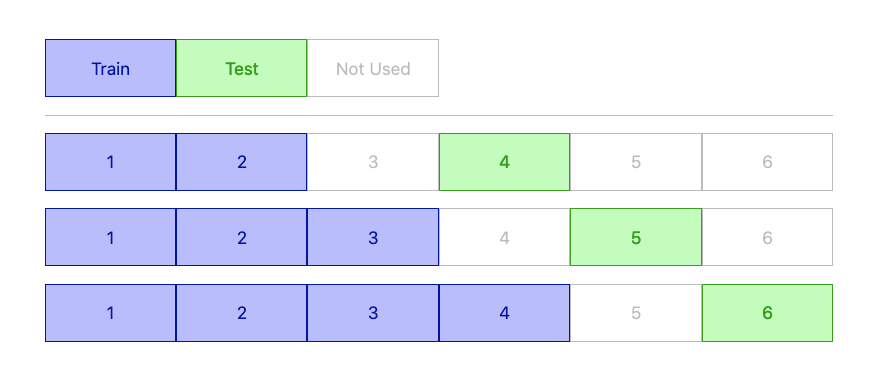

In [6]:
train_size=0.7

In [7]:
train_index = round(train_size)

# Percentage Base

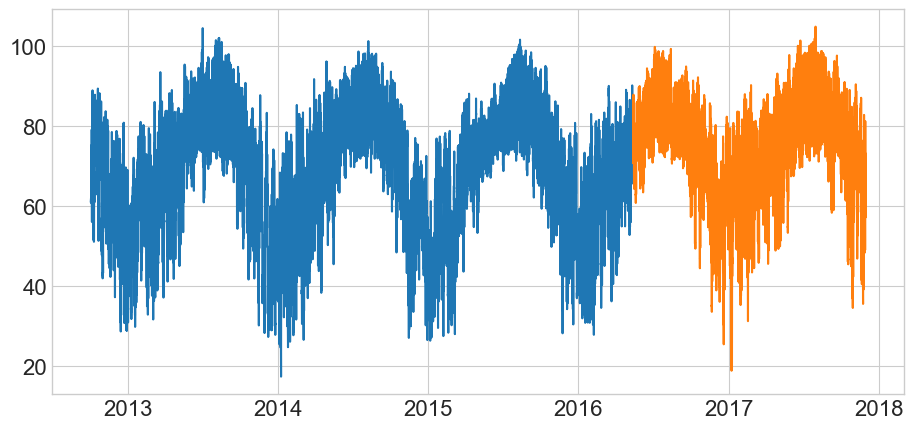

In [8]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)


# Human Base

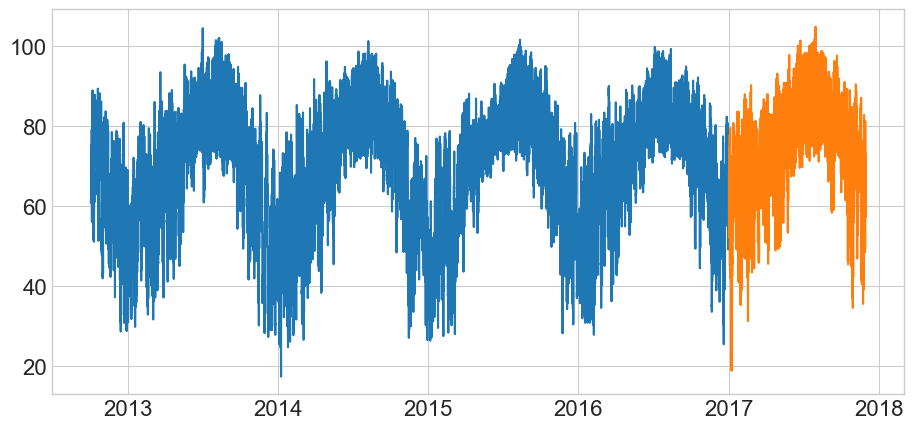

In [9]:
train = df[:'2016'] # includes 2016
test = df['2017']

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)


# Visualizations

In [10]:
y = train.temp
y.head()


datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

# Don't consider the time series

One of the first things we could do is to ignore the time series component of our data, and use all the other visualzation techniques we know to our data.

For example, we can make a histogram to show the distribution of our target variable:

<AxesSubplot:ylabel='Frequency'>

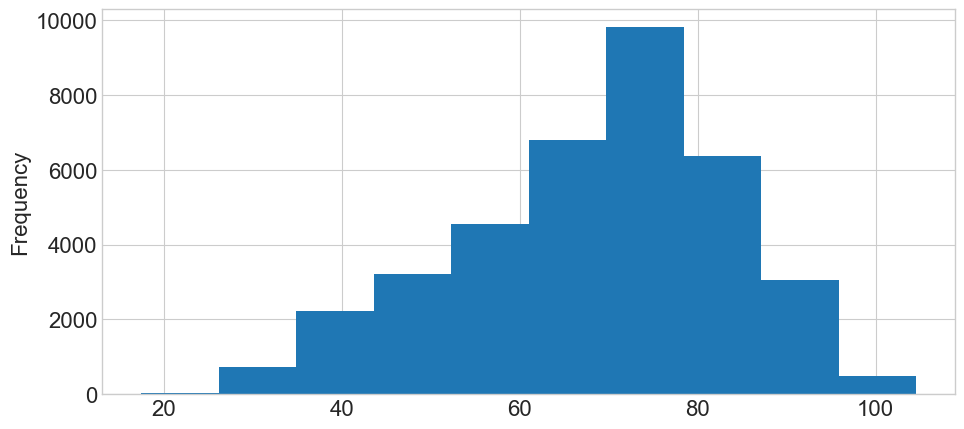

In [11]:
y.plot.hist()


# We could also treat components of the date as a seperate categorical feature.

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (F)')]

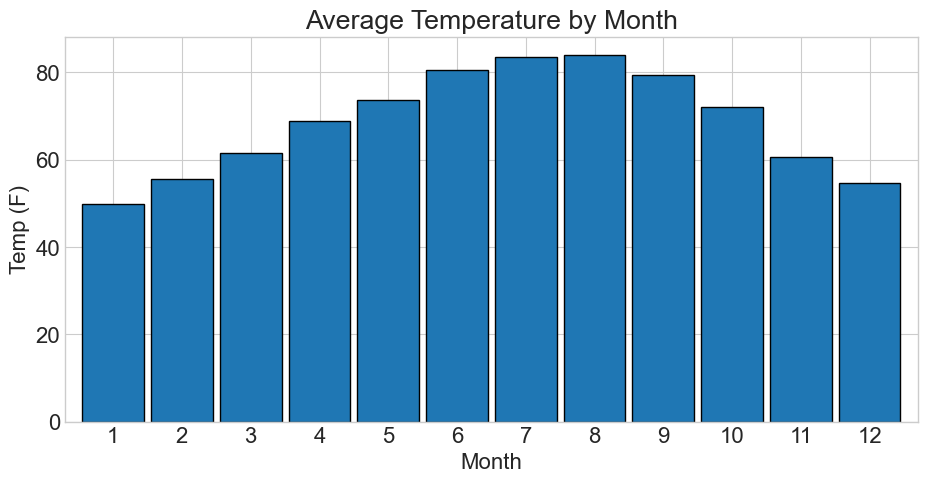

In [12]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)')


[Text(0.5, 1.0, 'Average Temperature by Weekday'),
 Text(0.5, 30.0, 'Weekday'),
 Text(30.0, 0.5, 'Temp (F)')]

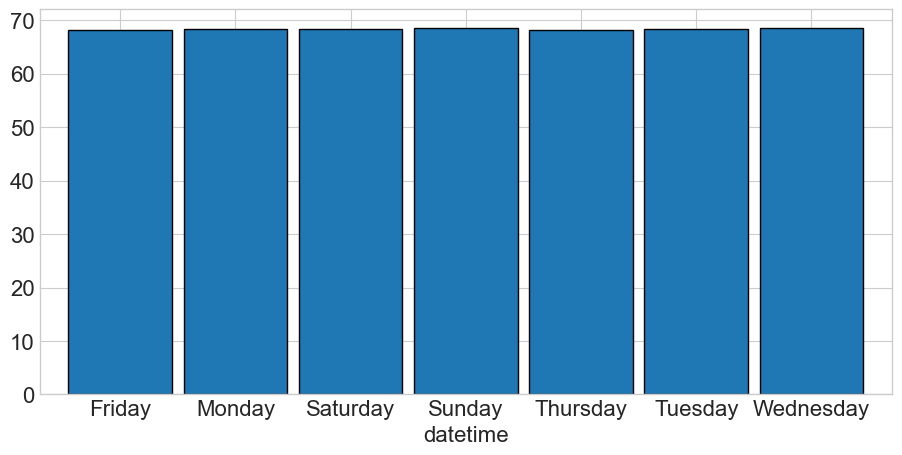

In [13]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Weekday', xlabel='Weekday', ylabel='Temp (F)')


<AxesSubplot:xlabel='weekday', ylabel='temp'>

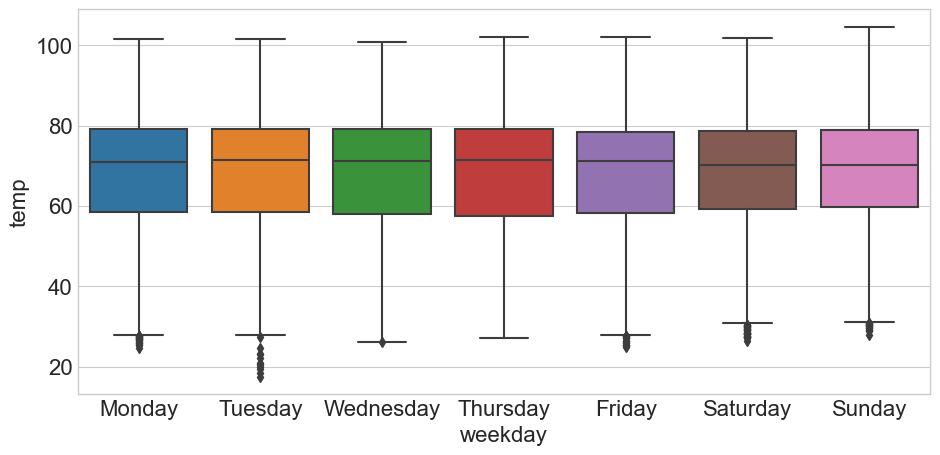

In [14]:
(
    y.reset_index()
    .assign(weekday=lambda df: df.datetime.dt.day_name())
    .pipe((sns.boxplot, 'data'), y='temp', x='weekday')
)


# Visualize the target over time

This can be as simple as calling .plot on a dataframe or series with a datetime index.

<AxesSubplot:xlabel='datetime'>

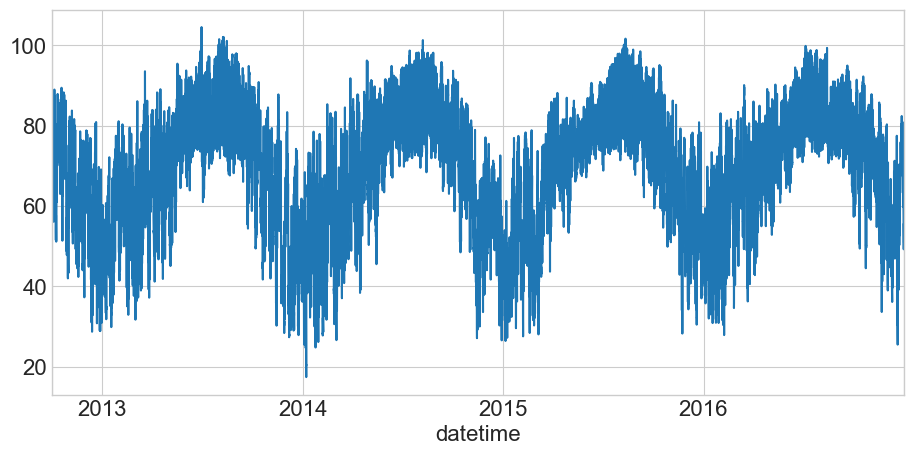

In [15]:
y.plot()


We can also resample our target and visualize it over various time periods.

<AxesSubplot:title={'center':'6 hour average'}, xlabel='datetime'>

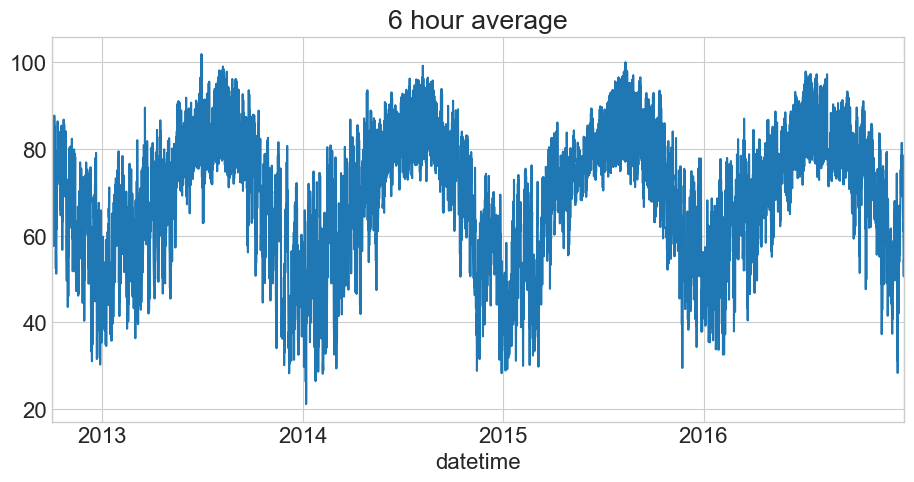

In [16]:
y.resample('6H').mean().plot(title='6 hour average')


<AxesSubplot:title={'center':'2 week average'}, xlabel='datetime'>

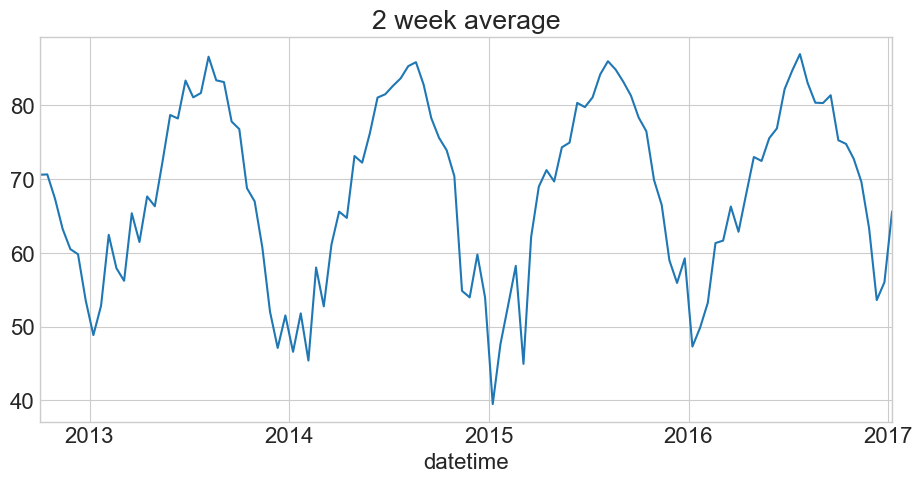

In [17]:
y.resample('2W').mean().plot(title='2 week average')


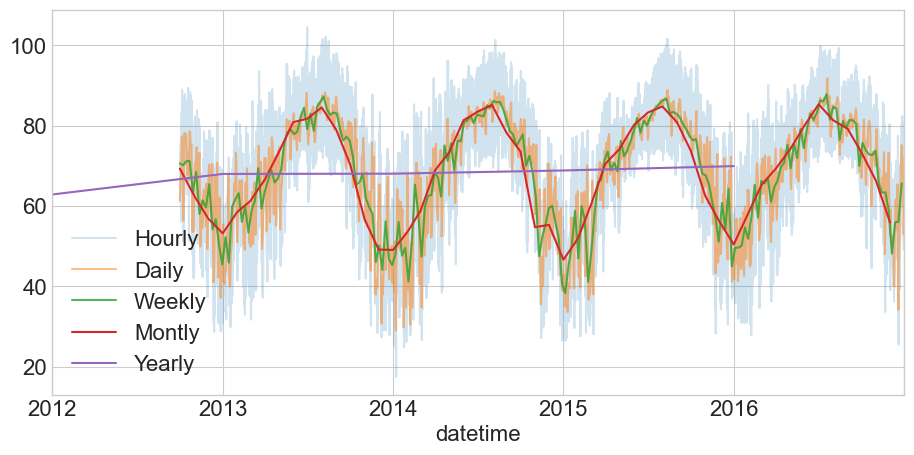

In [18]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


In addition to resampling, we can calculate moving averages with the .rolling method.

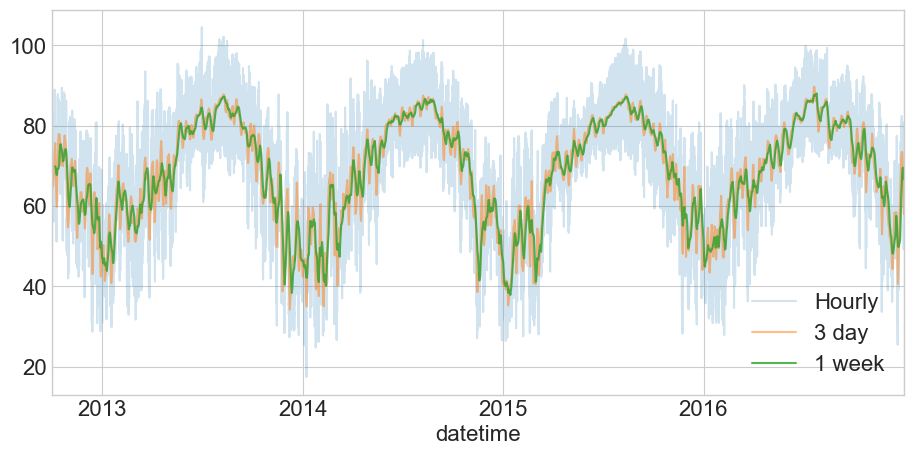

In [19]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()


# Visualize change over time

We can use the .diff method to visualize the change in temperature from one time period to the next.

<AxesSubplot:title={'center':'Average week-to-week change in temperature'}, xlabel='datetime'>

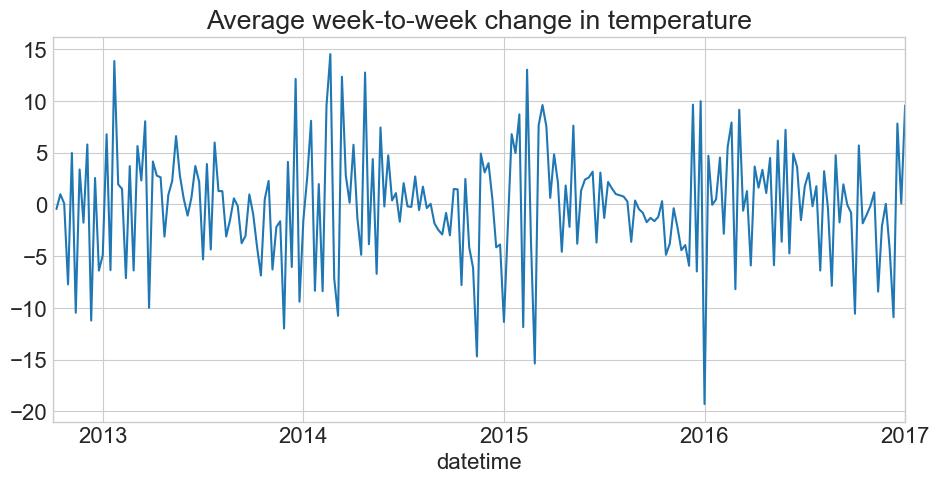

In [20]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in temperature')


<AxesSubplot:title={'center':'Average month-to-month change in temperature'}, xlabel='datetime'>

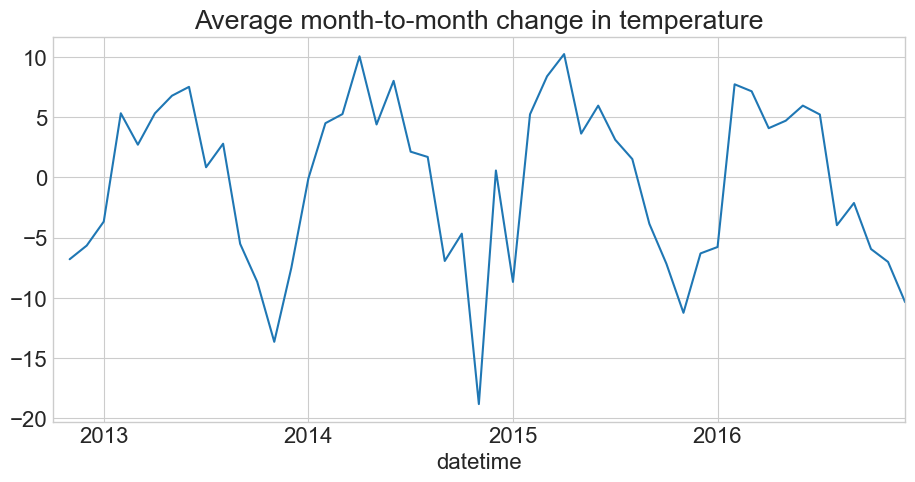

In [21]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature')


# Seasonal Plot

A seasonal plot is one that shows the comparison of multiple years together. It is another line plot with the x-axis being the month of the year and the y axis being the target variable. Multiple lines are shown to show multiple years.

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='datetime'>

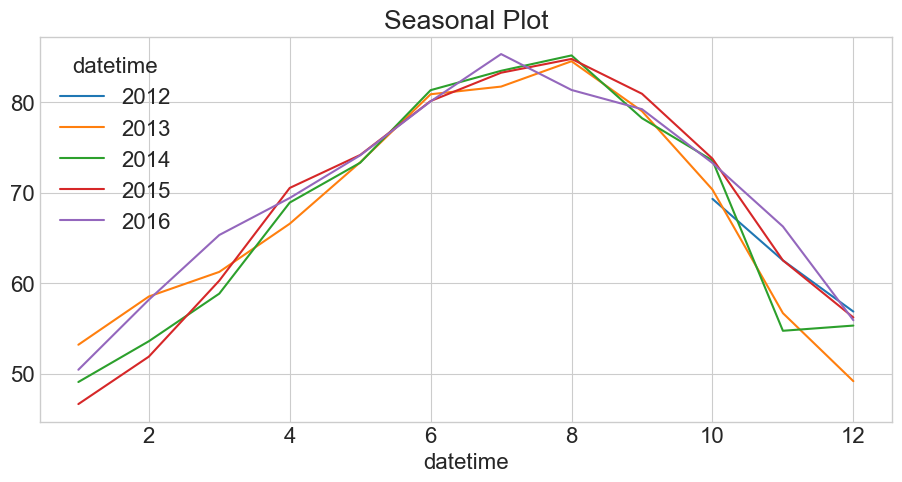

In [22]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


A seasonal plot can make it clear what year over year differences look like.

# Seasonal Subseries Plot

A seasonal subseries plot shows the change year-over-year within each month.

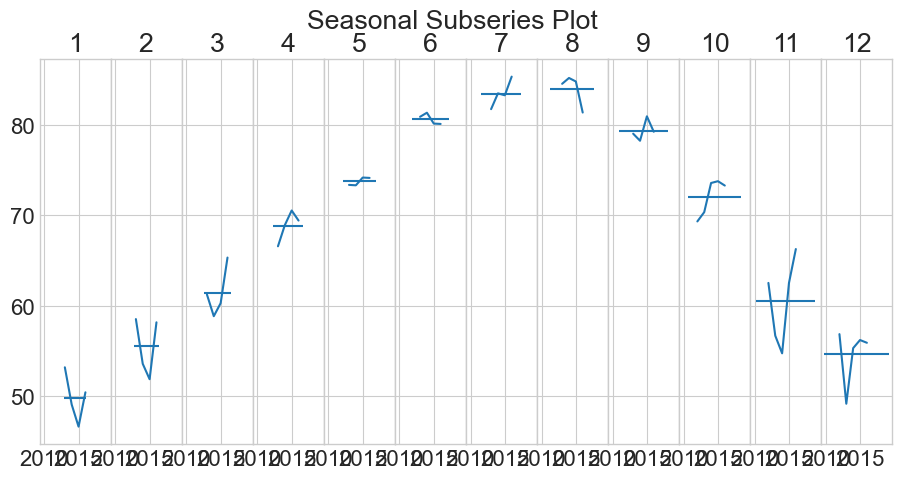

In [23]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


Here each subplot column represents one month, and within the each subplot we see how the average temperature for that month has changed from year to year. The dashed black line across the middle of each subplot represents the average temperature for that month.



# Lag Plot

A lag plot is a scatter plot of a series with itself, shifted, or lagged. Put another way, a lag plot measures one value against the next or previous value.

Text(0.5, 1.0, 'Lag plot with lag=1')

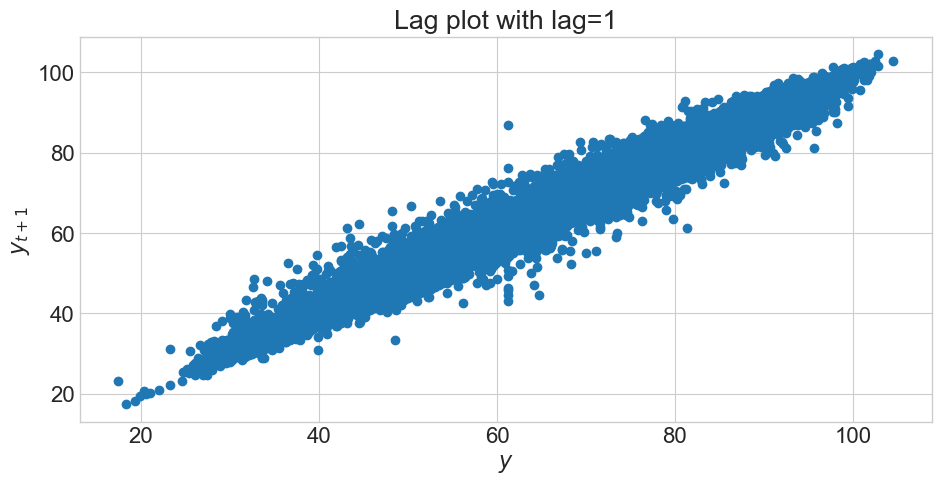

In [24]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

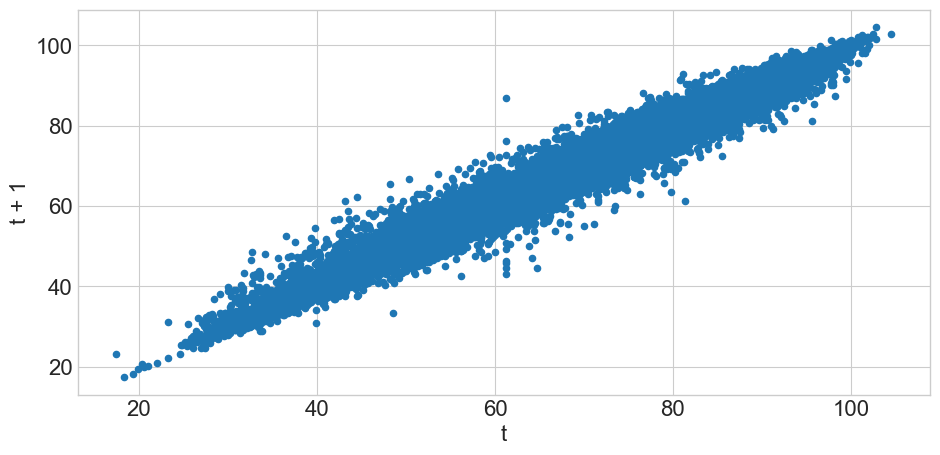

In [25]:
train['y(t + 1)'] = train.temp.shift(-1)
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')


In [26]:
del train['y(t + 1)']

The time unit is somewhat arbitrary so we could perform the same operation with weekly data.

this_week  the_next_week
datetime                            
2012-10-07  70.595201      70.152821
2012-10-14  70.152821      71.138375
2012-10-21  71.138375      71.230464
2012-10-28  71.230464      63.510554
2012-11-04  63.510554      68.482625
...               ...            ...
2016-12-04  59.062094      48.163625
2016-12-11  48.163625      55.979132
2016-12-18  55.979132      56.073143
2016-12-25  56.073143      65.640625
2017-01-01  65.640625            NaN

[222 rows x 2 columns]

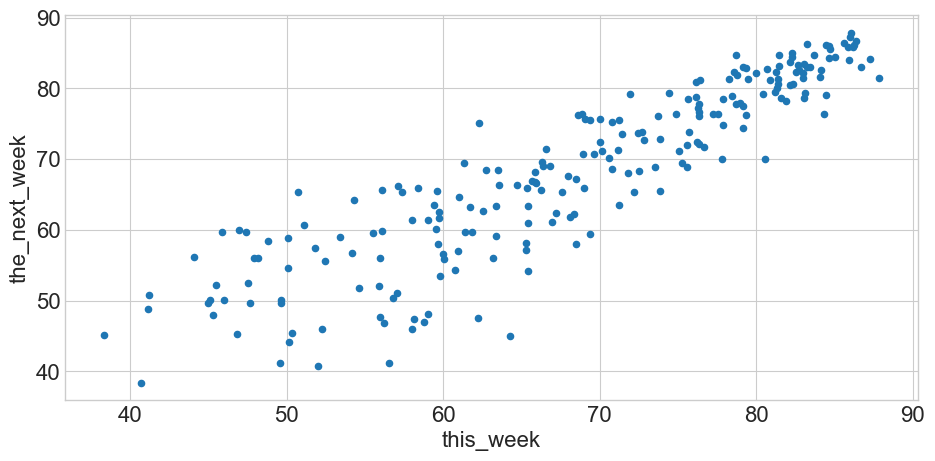

In [27]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly


Here we still see a fairly strong linear correlation. Let's take a look at a longer lag time.

this_week  12_weeks_out
datetime                           
2012-10-07  70.595201     50.376741
2012-10-14  70.152821     45.473616
2012-10-21  71.138375     52.252877
2012-10-28  71.230464     45.907936
2012-11-04  63.510554     59.763739
...               ...           ...
2016-12-04  59.062094           NaN
2016-12-11  48.163625           NaN
2016-12-18  55.979132           NaN
2016-12-25  56.073143           NaN
2017-01-01  65.640625           NaN

[222 rows x 2 columns]

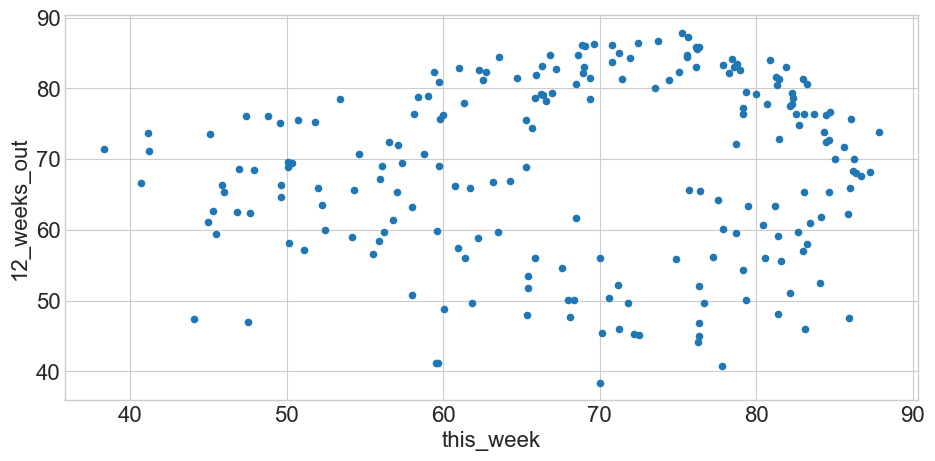

In [28]:
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly

Here we see no pattern.

this_week  half_a_year_later
datetime                                
2012-10-07  70.595201          63.558611
2012-10-14  70.152821          66.345532
2012-10-21  71.138375          68.965502
2012-10-28  71.230464          65.862071
2012-11-04  63.510554          66.797107
...               ...                ...
2016-12-04  59.062094                NaN
2016-12-11  48.163625                NaN
2016-12-18  55.979132                NaN
2016-12-25  56.073143                NaN
2017-01-01  65.640625                NaN

[222 rows x 2 columns]

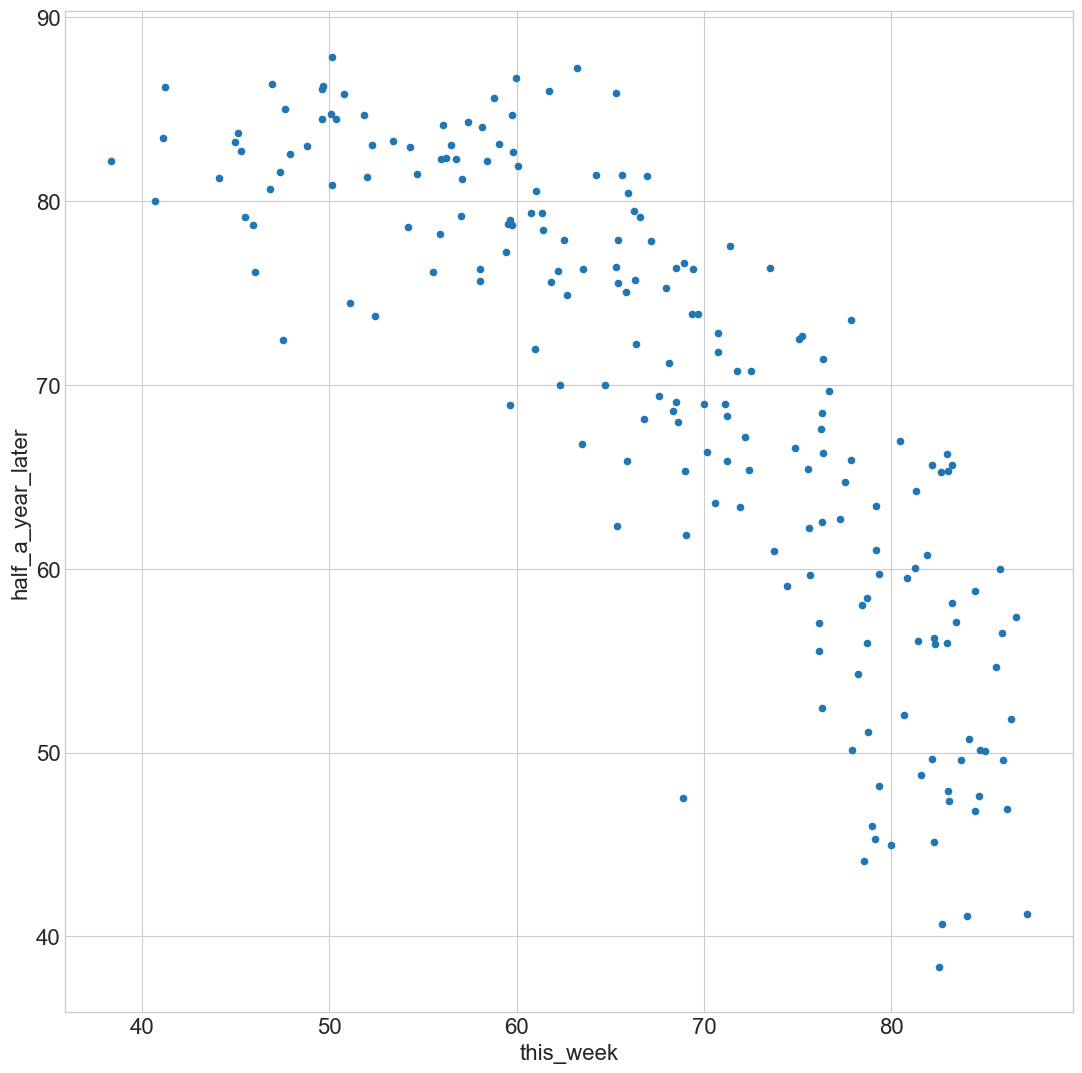

In [29]:
weekly = train.resample('W').mean()
weekly['half_a_year_later'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_a_year_later', figsize=(13, 13))
weekly

Notice here, at 26 weeks of lag, we observe a negative correlation.

Note that pandas has a built in lag_plot function that can do some of the work for us:

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

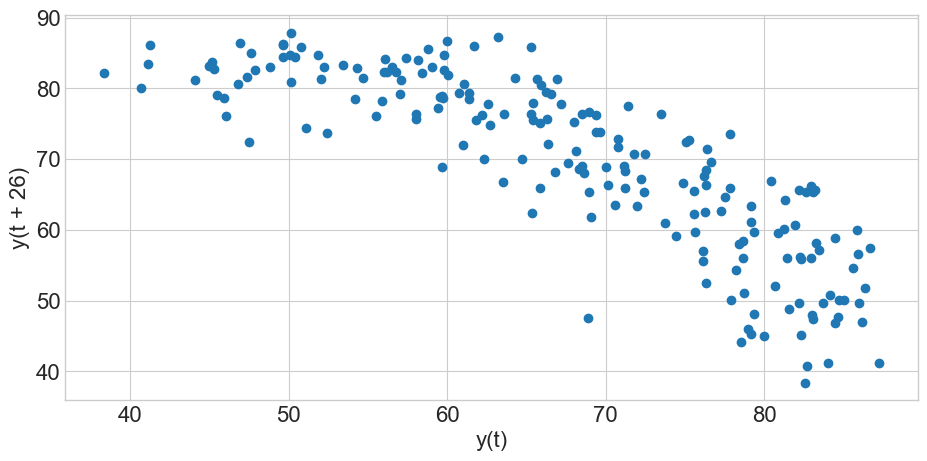

In [30]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=26)


# Autocorrelation Plot

Autocorrelation is a measure of the linear relationship between lagged values of a time series. An autocorrelation plot shows the correlation coefficient as a function of lag time.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

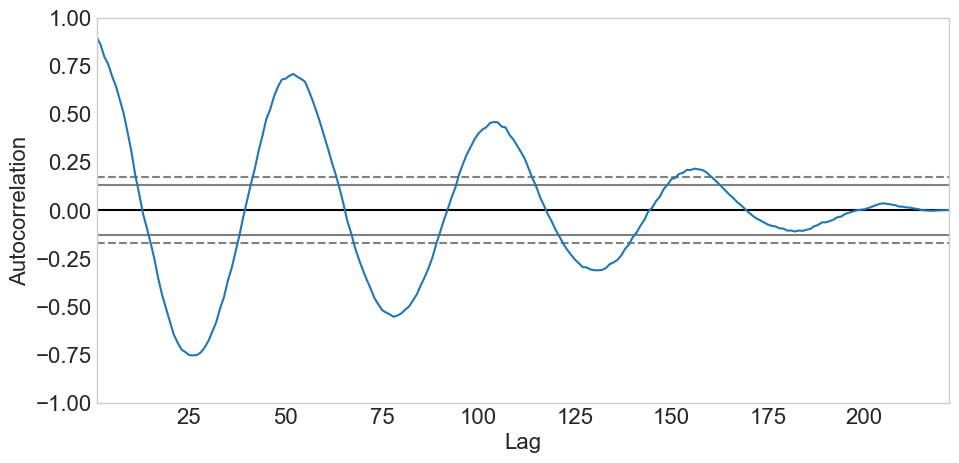

In [31]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

This can help us identify seasonality by looking at the peaks and valleys of the resulting visualization. The peaks can tells us the frequency with which the seasonality repeats itself, and the valleys show us where the correlation is the most negative.

The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise.

# Seasonal Decomposition

Seasonal decomposition is a fancy way to say that we can model time series as having 3 seperate components, the seasonal repeated cycle, the long term trend, and random noise1. There are two types of seasonal decomposition models, additive and multiplicative.

We can use the seasonal_decompose function from the statsmodels library to perform this decomposition.

In [32]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

y  trend  seasonal  resid
datetime                                     
2012-10-07  70.595201    NaN  8.545501    NaN
2012-10-14  70.152821    NaN  7.255470    NaN
2012-10-21  71.138375    NaN  2.468309    NaN
2012-10-28  71.230464    NaN  1.820126    NaN
2012-11-04  63.510554    NaN -0.114287    NaN

<AxesSubplot:xlabel='datetime'>

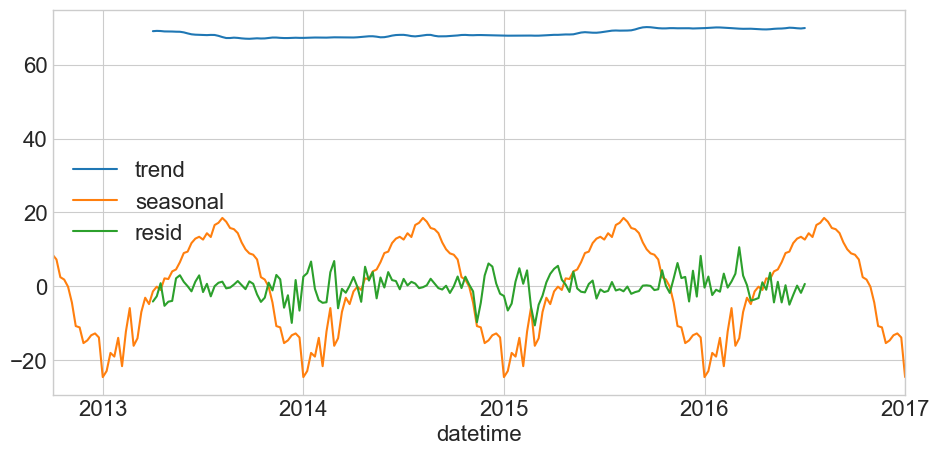

In [33]:
decomposition.iloc[:, 1:].plot()

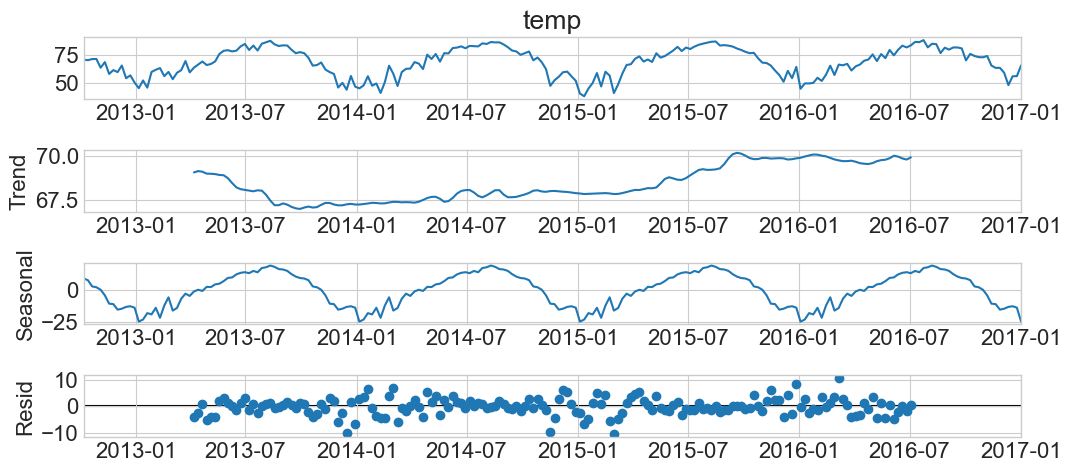

In [34]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


# Categories over time

How can we visualize categories over time?

In [35]:
train = train.resample('D').mean()
# create a categorical feature
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('temp_bin').mean()


temp
temp_bin           
cold      49.381699
cool      65.200219
warm      75.447977
hot       83.449087

How is the distribution of temp_bin changing over time?

Text(0, 0.5, '% of days in the month')

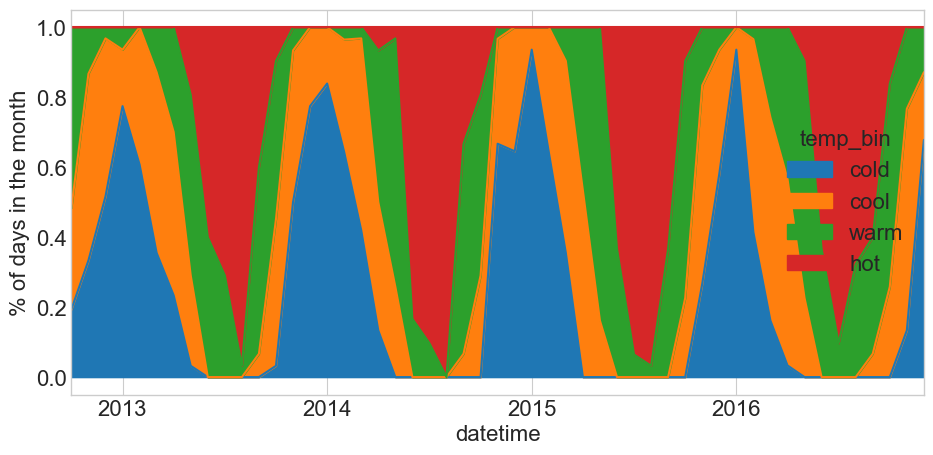

In [36]:
(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

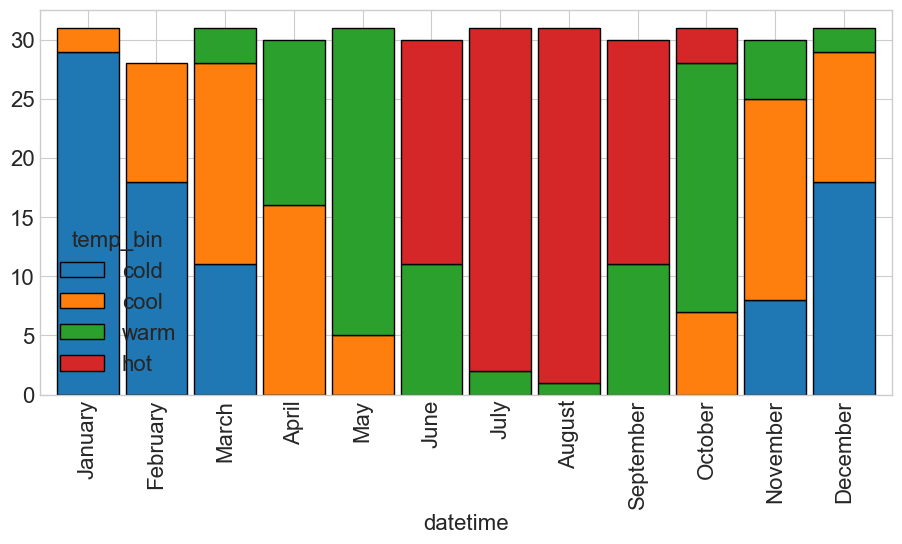

In [37]:
ax = (train['2015']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)


# strftime

A common problem we can run into when visualizing time series data is that the order of the months or days of the week logically is not the same as the order alphabetically. One workaround for this is to format the dates such that the have a number prepended to them (for example, 0-sunday, 1-monday) and the plot. Once the plot is created, we can manipulate the tick labels and remove the prefix.

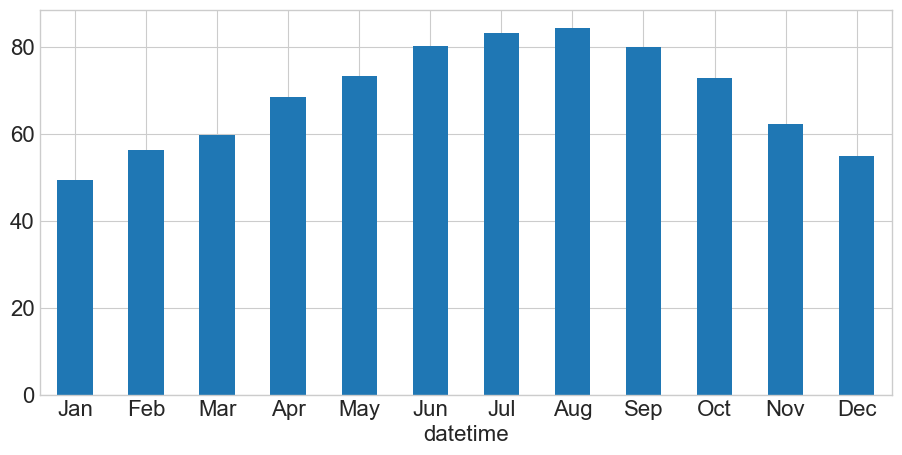

In [38]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None


# Matplotlib Dates

Manipulating Date Axes
If you wish to apply custom formatting to your axes, you should use plt.plot or ax.plot and pass the datetime index as your x values as opposed to using the built-in pandas plotting methods.

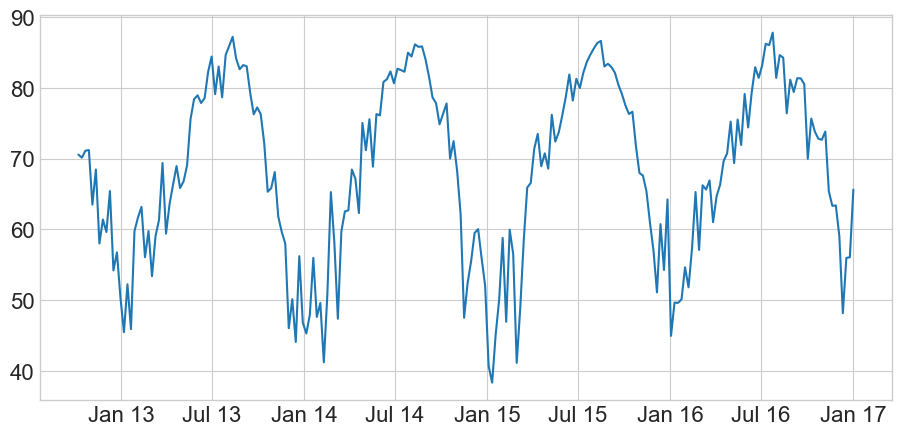

In [39]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

# Exercise

1. Do your work for this exercise in a notebook named explore. Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

2. For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split

In [40]:
df = acquire.wrangle_store_data()

In [41]:
df.isna().sum()

store_id         0
item_id          0
item_upc14       0
item_upc12       0
item_brand       0
item_name        0
item_price       1
sale_id          1
sale_date        1
sale_amount      1
store_address    1
store_zipcode    1
store_city       1
store_state      1
dtype: int64

In [42]:
df

store_id  item_id    item_upc14    item_upc12  item_brand  \
0             1        1   35200264013   35200264013    Riceland   
1             1        1   35200264013   35200264013    Riceland   
2             1        1   35200264013   35200264013    Riceland   
3             1        1   35200264013   35200264013    Riceland   
4             1        1   35200264013   35200264013    Riceland   
...         ...      ...           ...           ...         ...   
28927         1       16  792850014008  792850014008  Burts Bees   
28928         1       16  792850014008  792850014008  Burts Bees   
28929         1       16  792850014008  792850014008  Burts Bees   
28930         1       16  792850014008  792850014008  Burts Bees   
28931         1       16  792850014008  792850014008  Burts Bees   

                                           item_name  item_price   sale_id  \
0                     Riceland American Jazmine Rice        0.84       1.0   
1                     Riceland American Jazmine Rice        0.84       2.0   
2                     Riceland American Jazmine Rice        0.84       3.0   
3                     Riceland American Jazmine Rice        0.84       4.0   
4                     Riceland American Jazmine Rice        0.84       5.0   
...                                              ...         ...       ...   
28927  Burts Bees Daily Moisturizing Cream Sensitive        5.17  275438.0   
28928  Burts Bees Daily Moisturizing Cream Sensitive        5.17  275439.0   
28929  Burts Bees Daily Moisturizing Cream Sensitive        5.17  275440.0   
28930  Burts Bees Daily Moisturizing Cream Sensitive        5.17  275441.0   
28931                    Burts Bees Daily Moisturizi         NaN       NaN   

        sale_date  sale_amount           store_address  store_zipcode  \
0      2013-01-01         13.0  12125 Alamo Ranch Pkwy        78253.0   
1      2013-01-02         11.0  12125 Alamo Ranch Pkwy        78253.0   
2      2013-01-03         14.0  12125 Alamo Ranch Pkwy        78253.0   
3      2013-01-04         13.0  12125 Alamo Ranch Pkwy        78253.0   
4      2013-01-05         10.0  12125 Alamo Ranch Pkwy        78253.0   
...           ...          ...                     ...            ...   
28927  2017-03-18         29.0  12125 Alamo Ranch Pkwy        78253.0   
28928  2017-03-19         33.0  12125 Alamo Ranch Pkwy        78253.0   
28929  2017-03-20         21.0  12125 Alamo Ranch Pkwy        78253.0   
28930  2017-03-21         18.0  12125 Alamo Ranch Pkwy        78253.0   
28931         NaN          NaN                     NaN            NaN   

        store_city store_state  
0      San Antonio          TX  
1      San Antonio          TX  
2      San Antonio          TX  
3      San Antonio          TX  
4      San Antonio          TX  
...            ...         ...  
28927  San Antonio          TX  
28928  San Antonio          TX  
28929  San Antonio          TX  
28930  San Antonio          TX  
28931          NaN         NaN  

[28932 rows x 14 columns]

In [43]:
df= df.fillna(method='ffill')

In [44]:
df.isna().sum()

store_id         0
item_id          0
item_upc14       0
item_upc12       0
item_brand       0
item_name        0
item_price       0
sale_id          0
sale_date        0
sale_amount      0
store_address    0
store_zipcode    0
store_city       0
store_state      0
dtype: int64

In [45]:
df=prepare.prepare_store_data(df)

In [46]:
df

store_id  item_id    item_upc14    item_upc12          item_brand  \
sale_date                                                                       
2013-01-01         1        1   35200264013   35200264013            Riceland   
2013-01-01         1        7   70177154004   70177154004  Twinings Of London   
2013-01-01         1       14   41167300121   41167300121             Pamprin   
2013-01-01         1        4  208528800007  208528800007          Boars Head   
2013-01-01         1       11  657622604842  657622604842          Honest Tea   
...              ...      ...           ...           ...                 ...   
2017-12-31         1        8   51600080015   51600080015       Lea & Perrins   
2017-12-31         1       14   41167300121   41167300121             Pamprin   
2017-12-31         1        6   74170388732   74170388732        Sally Hansen   
2017-12-31         1        4  208528800007  208528800007          Boars Head   
2017-12-31         1        7   70177154004   70177154004  Twinings Of London   

                                                    item_name  item_price  \
sale_date                                                                   
2013-01-01                     Riceland American Jazmine Rice        0.84   
2013-01-01  Twinings Of London Classics Lady Grey Tea - 20 Ct        9.64   
2013-01-01  Pamprin Maximum Strength Multi-symptom Menstru...        7.54   
2013-01-01   Boars Head Sliced White American Cheese - 120 Ct        3.14   
2013-01-01                         Honest Tea Peach White Tea        3.93   
...                                                       ...         ...   
2017-12-31  Lea & Perrins Marinade In-a-bag Cracked Pepper...        1.68   
2017-12-31  Pamprin Maximum Strength Multi-symptom Menstru...        7.54   
2017-12-31  Sally Hansen Nail Color Magnetic 903 Silver El...        6.93   
2017-12-31   Boars Head Sliced White American Cheese - 120 Ct        3.14   
2017-12-31  Twinings Of London Classics Lady Grey Tea - 20 Ct        9.64   

             sale_id  sale_amount           store_address  store_zipcode  \
sale_date                                                                  
2013-01-01       1.0         13.0  12125 Alamo Ranch Pkwy        78253.0   
2013-01-01  109561.0         25.0  12125 Alamo Ranch Pkwy        78253.0   
2013-01-01  237381.0         22.0  12125 Alamo Ranch Pkwy        78253.0   
2013-01-01   54781.0         10.0  12125 Alamo Ranch Pkwy        78253.0   
2013-01-01  182601.0         37.0  12125 Alamo Ranch Pkwy        78253.0   
...              ...          ...                     ...            ...   
2017-12-31  129646.0         62.0  12125 Alamo Ranch Pkwy        78253.0   
2017-12-31  239206.0         52.0  12125 Alamo Ranch Pkwy        78253.0   
2017-12-31   93126.0         53.0  12125 Alamo Ranch Pkwy        78253.0   
2017-12-31   56606.0         15.0  12125 Alamo Ranch Pkwy        78253.0   
2017-12-31  111386.0         55.0  12125 Alamo Ranch Pkwy        78253.0   

             store_city store_state     month day_of_week  sales_total  
sale_date                                                               
2013-01-01  San Antonio          TX   January     Tuesday        10.92  
2013-01-01  San Antonio          TX   January     Tuesday       241.00  
2013-01-01  San Antonio          TX   January     Tuesday       165.88  
2013-01-01  San Antonio          TX   January     Tuesday        31.40  
2013-01-01  San Antonio          TX   January     Tuesday       145.41  
...                 ...         ...       ...         ...          ...  
2017-12-31  San Antonio          TX  December      Sunday       104.16  
2017-12-31  San Antonio          TX  December      Sunday       392.08  
2017-12-31  San Antonio          TX  December      Sunday       367.29  
2017-12-31  San Antonio          TX  December      Sunday        47.10  
2017-12-31  San Antonio          TX  December      Sunday       530.20  

[28932 rows x 16 

# Data Splitting

Ideally all splits contain a season
Human-based: use the last year as test
Percentage based: use the last 20% as test
Cross Validate: break data up into slices and use successive slices as train and test repeatedly (sklearn.model_selection.TimeSeriesSplit)  image.png

# Percentage-Based

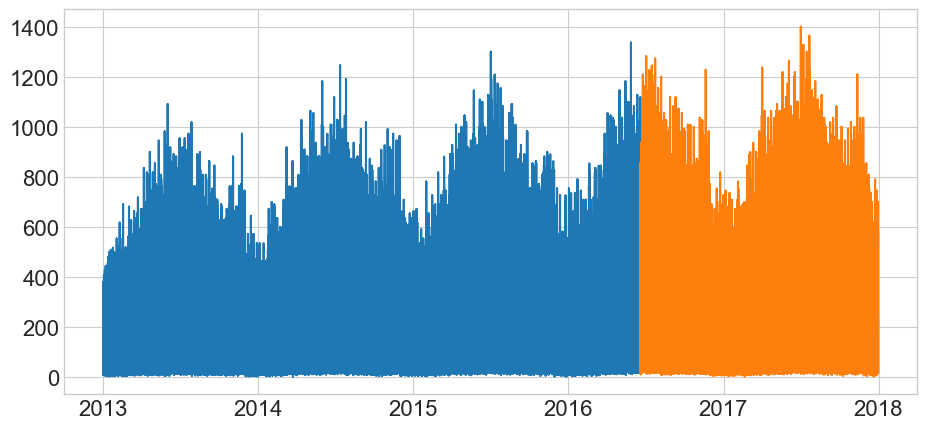

In [47]:
#Separate validate here too to keep from having to do it later. 

train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.sales_total)
plt.plot(test.index, test.sales_total)


# Human-Based 
train = df[:'2016'] # includes 2016

test = df['2017']

plt.plot(train.index, train.temp)

plt.plot(test.index, test.temp)


In [48]:
y = train.sales_total
y.head()


sale_date
2013-01-01     10.92
2013-01-01    241.00
2013-01-01    165.88
2013-01-01     31.40
2013-01-01    145.41
Name: sales_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

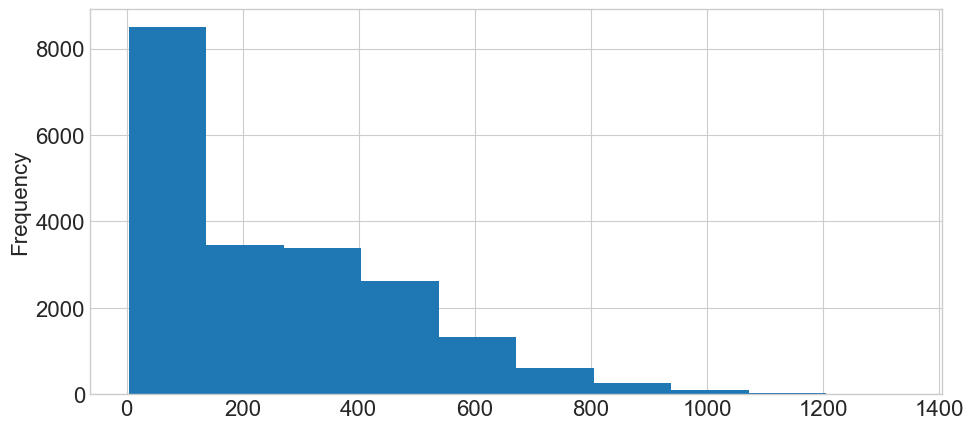

In [49]:
y.plot.hist()


[Text(0.5, 1.0, 'Average Sales Total by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Sales Total')]

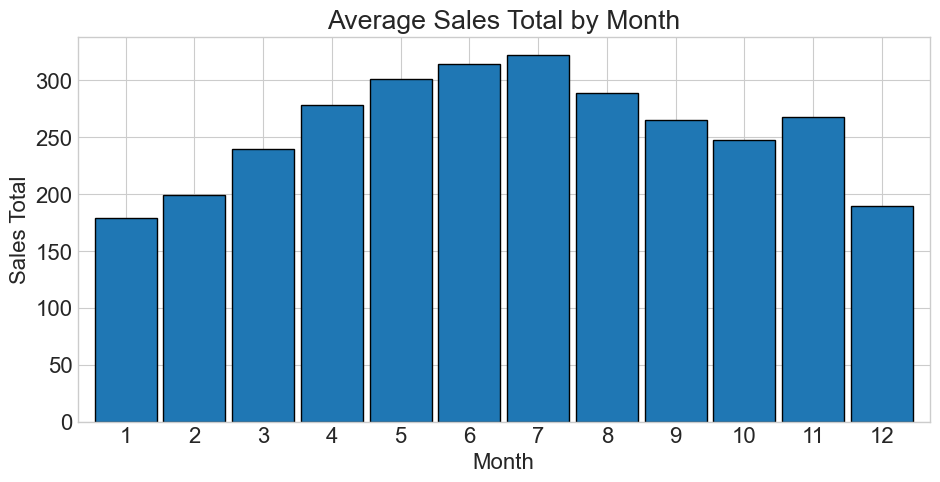

In [50]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales Total by Month', xlabel='Month', ylabel='Sales Total')

[Text(0.5, 1.0, 'Average Sales Total by Weekday'),
 Text(0.5, 30.0, 'Weekday'),
 Text(29.999999999999986, 0.5, 'Sales Total')]

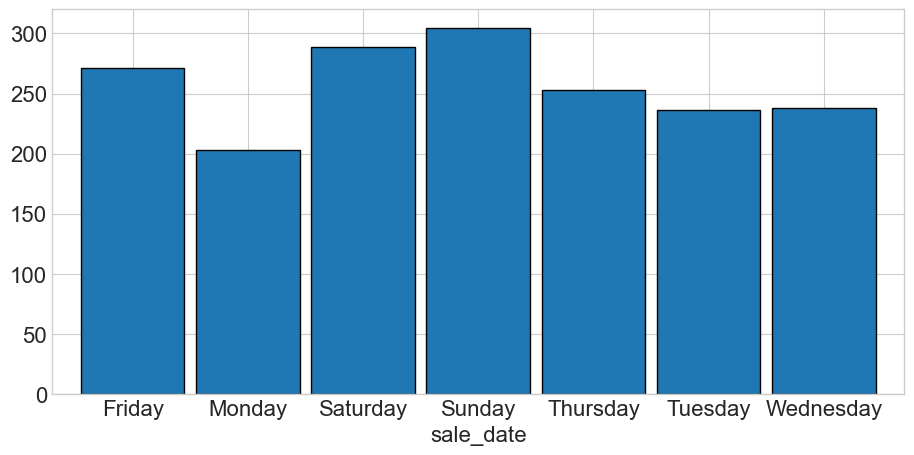

In [51]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales Total by Weekday', xlabel='Weekday', ylabel='Sales Total')


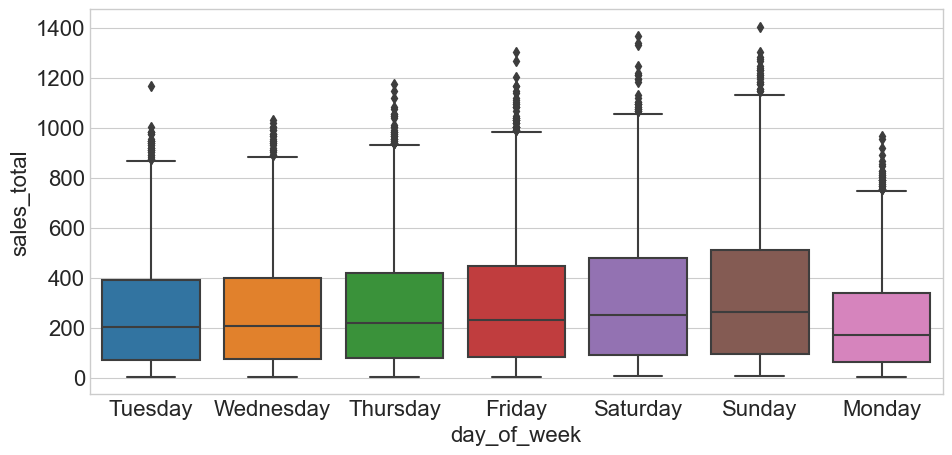

In [52]:
sns.boxplot( y=df["sales_total"], x=df['day_of_week'] );
plt.show()

<AxesSubplot:xlabel='sale_date'>

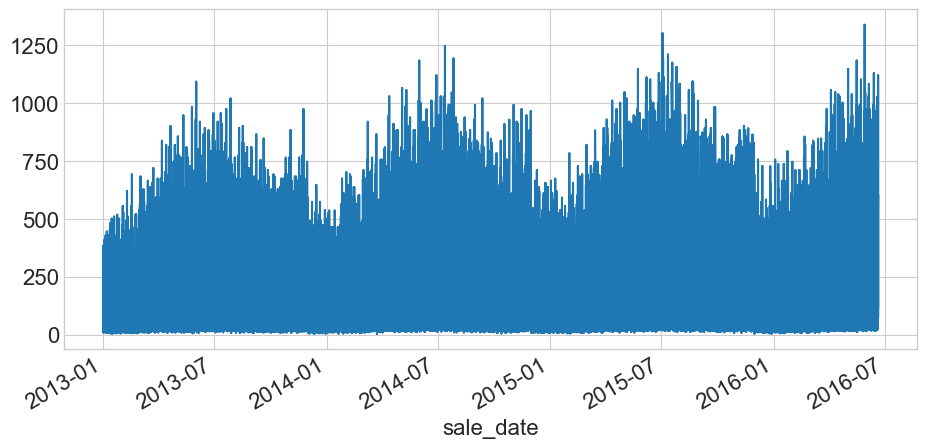

In [53]:
y.plot()

<AxesSubplot:title={'center':'6 Month Average'}, xlabel='sale_date'>

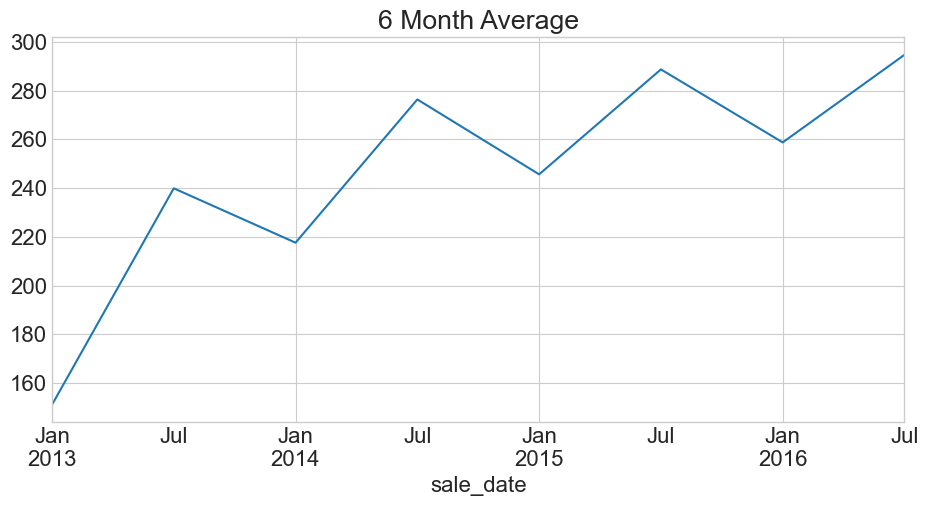

In [54]:
y.resample('6M').mean().plot(title='6 Month Average')


<AxesSubplot:title={'center':'2 week average'}, xlabel='sale_date'>

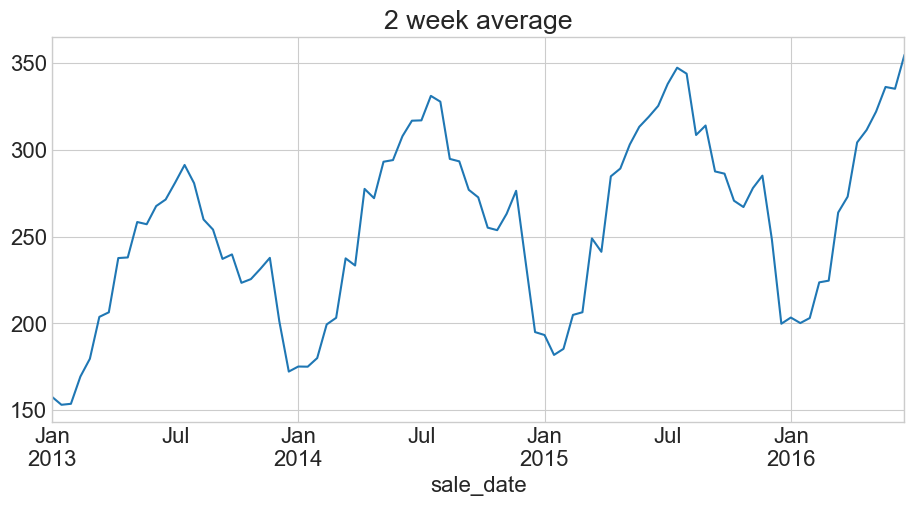

In [55]:
y.resample('2W').mean().plot(title='2 week average')


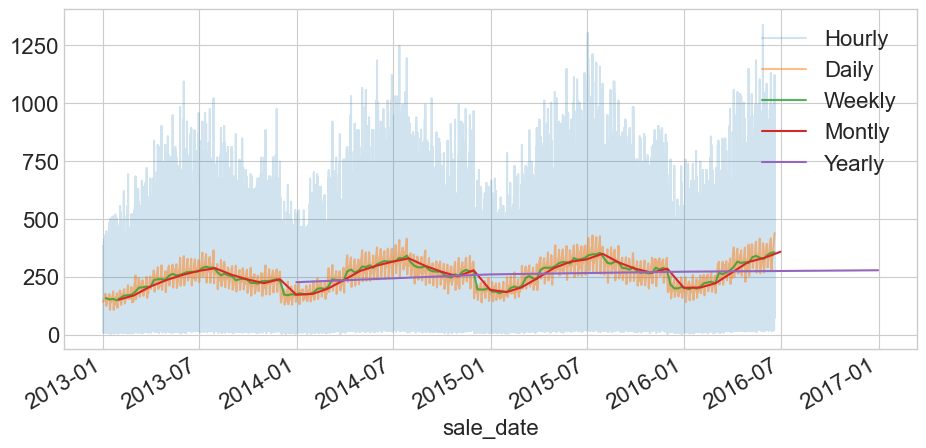

In [56]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


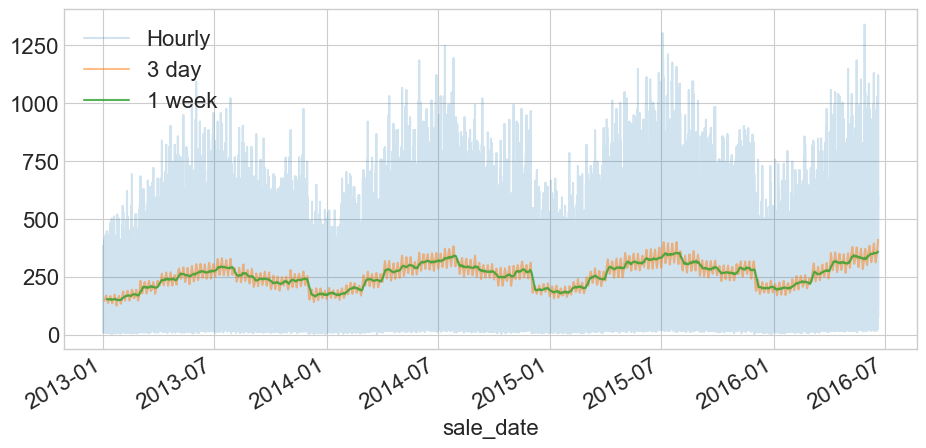

In [57]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()


<AxesSubplot:title={'center':'Average month-to-month change in Sales Totals'}, xlabel='sale_date'>

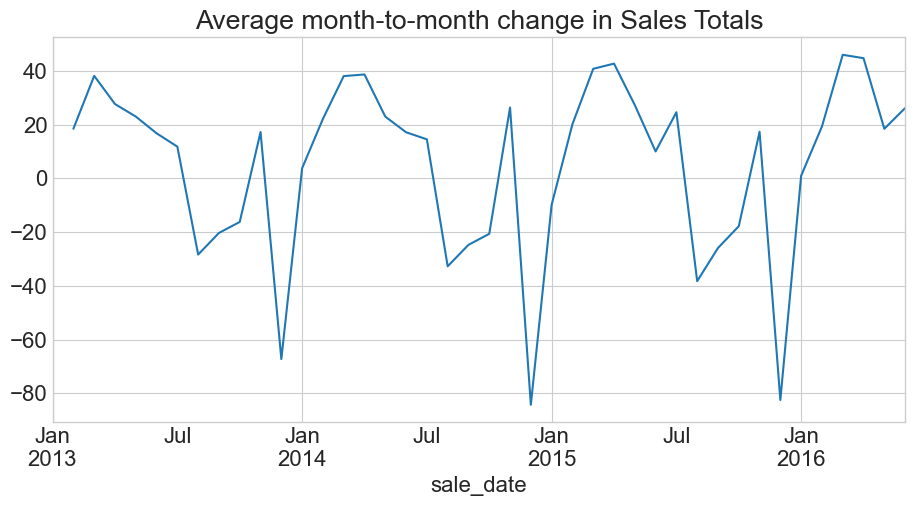

In [58]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in Sales Totals')


<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='sale_date'>

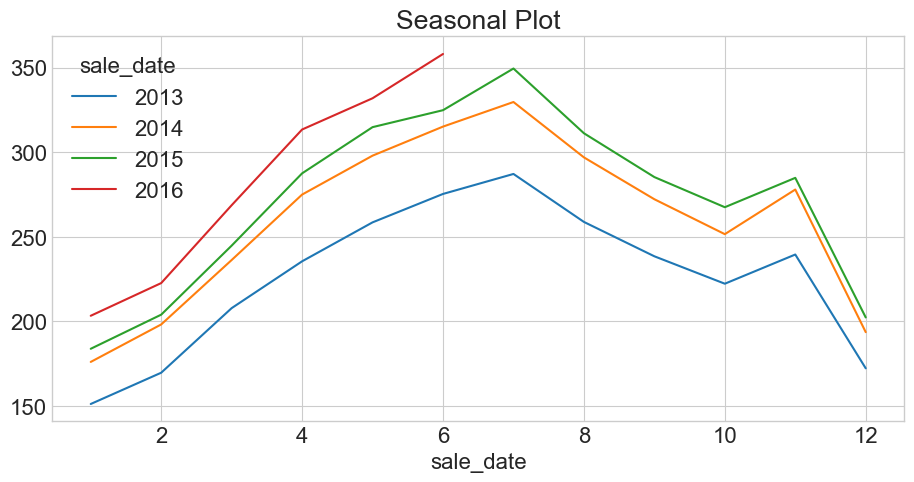

In [59]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


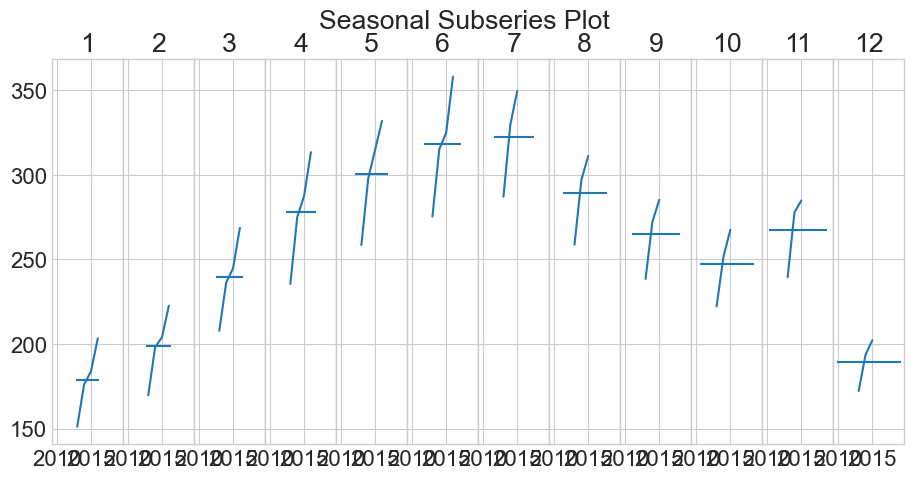

In [60]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


Text(0.5, 1.0, 'Lag plot with lag=1')

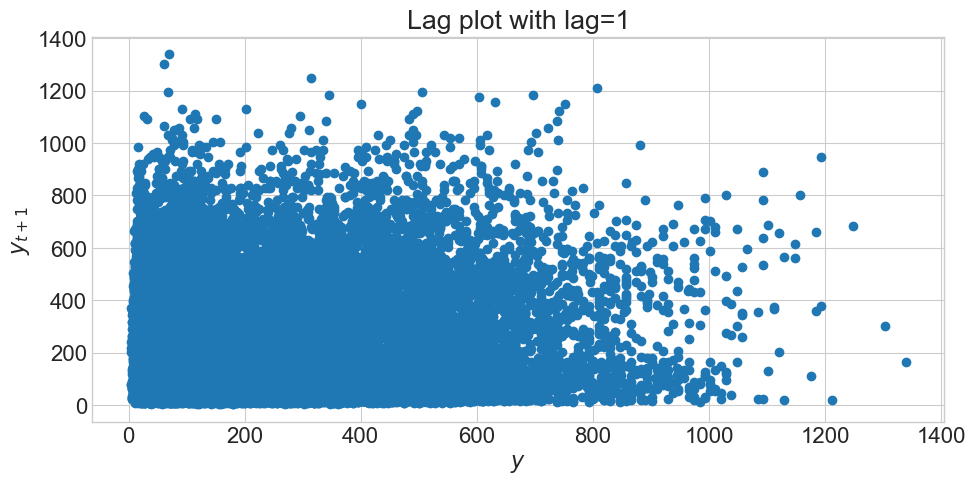

In [61]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

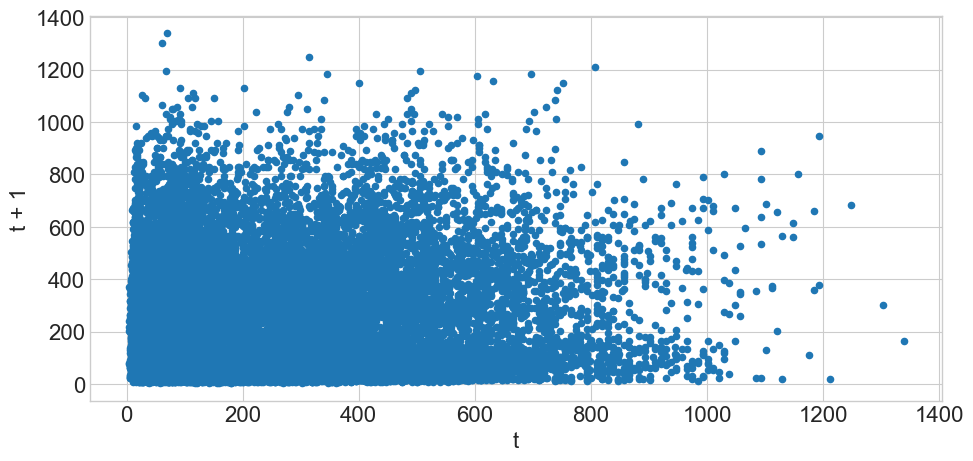

In [62]:
train['y(t + 1)'] = train.sales_total.shift(-1)
ax = train.plot.scatter(x='sales_total', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')


store_id   item_id    item_upc14    item_upc12  item_price  \
sale_date                                                                
2013-01-06       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-13       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-20       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-27       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-02-03       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
...              ...       ...           ...           ...         ...   
2016-05-22       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-05-29       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-05       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-12       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-19       1.0  8.601852  2.679821e+11  2.679821e+11    4.960370   

                  sale_id  sale_amount  store_zipcode   this_week    y(t + 1)  \
sale_date                                                                       
2013-01-06  136953.500000    29.114583        78253.0  157.809687  159.738021   
2013-01-13  136960.000000    27.214286        78253.0  152.459286  151.946429   
2013-01-20  136967.000000    27.741071        78253.0  153.989911  153.260179   
2013-01-27  136974.000000    26.892857        78253.0  148.406518  148.818750   
2013-02-03  136981.000000    28.919643        78253.0  159.180536  158.568929   
...                   ...          ...            ...         ...         ...   
2016-05-22  138185.000000    60.732143        78253.0  332.019643  335.348036   
2016-05-29  138192.000000    59.580357        78253.0  327.180446  324.221339   
2016-06-05  138199.000000    62.750000        78253.0  342.856786  341.829107   
2016-06-12  138206.000000    64.133929        78253.0  353.373750  355.131161   
2016-06-19  140072.703704    64.481481        78253.0  355.792870  357.097944   

            the_next_week  
sale_date                  
2013-01-06     152.459286  
2013-01-13     153.989911  
2013-01-20     148.406518  
2013-01-27     159.180536  
2013-02-03     169.031607  
...                   ...  
2016-05-22     327.180446  
2016-05-29     342.856786  
2016-06-05     353.373750  
2016-06-12     355.792870  
2016-06-19            NaN  

[181 rows x 11 columns]

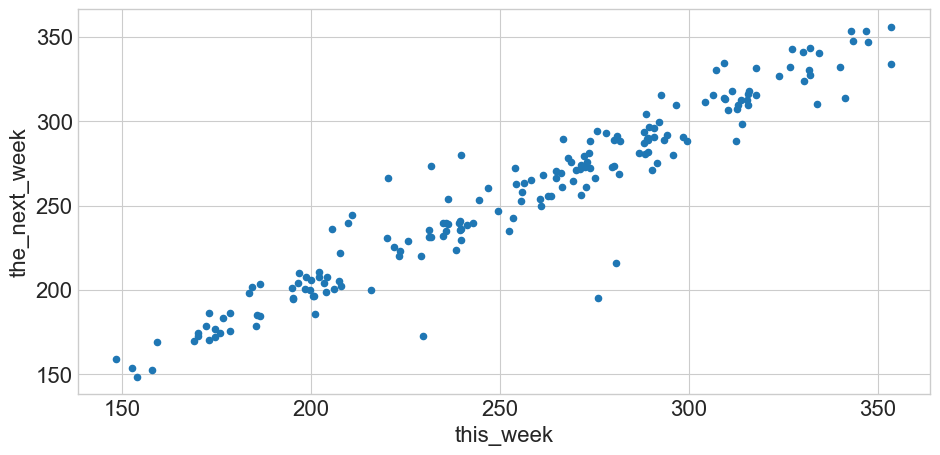

In [63]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.sales_total.shift(-1)
weekly = weekly.rename(columns={'sales_total': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly


store_id   item_id    item_upc14    item_upc12  item_price  \
sale_date                                                                
2013-01-06       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-13       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-20       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-27       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-02-03       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
...              ...       ...           ...           ...         ...   
2016-05-22       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-05-29       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-05       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-12       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-19       1.0  8.601852  2.679821e+11  2.679821e+11    4.960370   

                  sale_id  sale_amount  store_zipcode   this_week    y(t + 1)  \
sale_date                                                                       
2013-01-06  136953.500000    29.114583        78253.0  157.809687  159.738021   
2013-01-13  136960.000000    27.214286        78253.0  152.459286  151.946429   
2013-01-20  136967.000000    27.741071        78253.0  153.989911  153.260179   
2013-01-27  136974.000000    26.892857        78253.0  148.406518  148.818750   
2013-02-03  136981.000000    28.919643        78253.0  159.180536  158.568929   
...                   ...          ...            ...         ...         ...   
2016-05-22  138185.000000    60.732143        78253.0  332.019643  335.348036   
2016-05-29  138192.000000    59.580357        78253.0  327.180446  324.221339   
2016-06-05  138199.000000    62.750000        78253.0  342.856786  341.829107   
2016-06-12  138206.000000    64.133929        78253.0  353.373750  355.131161   
2016-06-19  140072.703704    64.481481        78253.0  355.792870  357.097944   

            12_weeks_out  
sale_date                 
2013-01-06    205.469464  
2013-01-13    236.213571  
2013-01-20    239.057768  
2013-01-27    239.712054  
2013-02-03    236.252143  
...                  ...  
2016-05-22           NaN  
2016-05-29           NaN  
2016-06-05           NaN  
2016-06-12           NaN  
2016-06-19           NaN  

[181 rows x 11 columns]

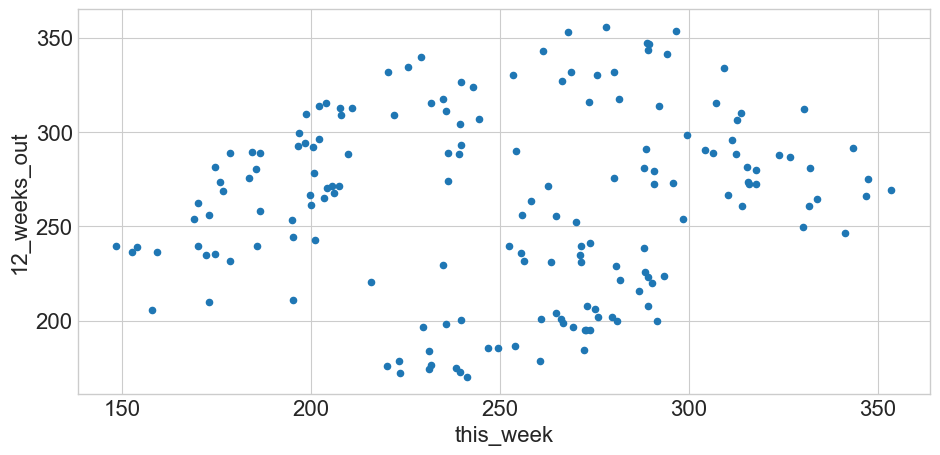

In [64]:
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.sales_total.shift(-12)
weekly = weekly.rename(columns={'sales_total': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly


store_id   item_id    item_upc14    item_upc12  item_price  \
sale_date                                                                
2013-01-06       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-13       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-20       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-01-27       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2013-02-03       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
...              ...       ...           ...           ...         ...   
2016-05-22       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-05-29       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-05       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-12       1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
2016-06-19       1.0  8.601852  2.679821e+11  2.679821e+11    4.960370   

                  sale_id  sale_amount  store_zipcode   this_week    y(t + 1)  \
sale_date                                                                       
2013-01-06  136953.500000    29.114583        78253.0  157.809687  159.738021   
2013-01-13  136960.000000    27.214286        78253.0  152.459286  151.946429   
2013-01-20  136967.000000    27.741071        78253.0  153.989911  153.260179   
2013-01-27  136974.000000    26.892857        78253.0  148.406518  148.818750   
2013-02-03  136981.000000    28.919643        78253.0  159.180536  158.568929   
...                   ...          ...            ...         ...         ...   
2016-05-22  138185.000000    60.732143        78253.0  332.019643  335.348036   
2016-05-29  138192.000000    59.580357        78253.0  327.180446  324.221339   
2016-06-05  138199.000000    62.750000        78253.0  342.856786  341.829107   
2016-06-12  138206.000000    64.133929        78253.0  353.373750  355.131161   
2016-06-19  140072.703704    64.481481        78253.0  355.792870  357.097944   

            half_a_year_later  
sale_date                      
2013-01-06         288.141250  
2013-01-13         293.341696  
2013-01-20         289.040357  
2013-01-27         290.137321  
2013-02-03         271.288571  
...                       ...  
2016-05-22                NaN  
2016-05-29                NaN  
2016-06-05                NaN  
2016-06-12                NaN  
2016-06-19                NaN  

[181 rows x 11 columns]

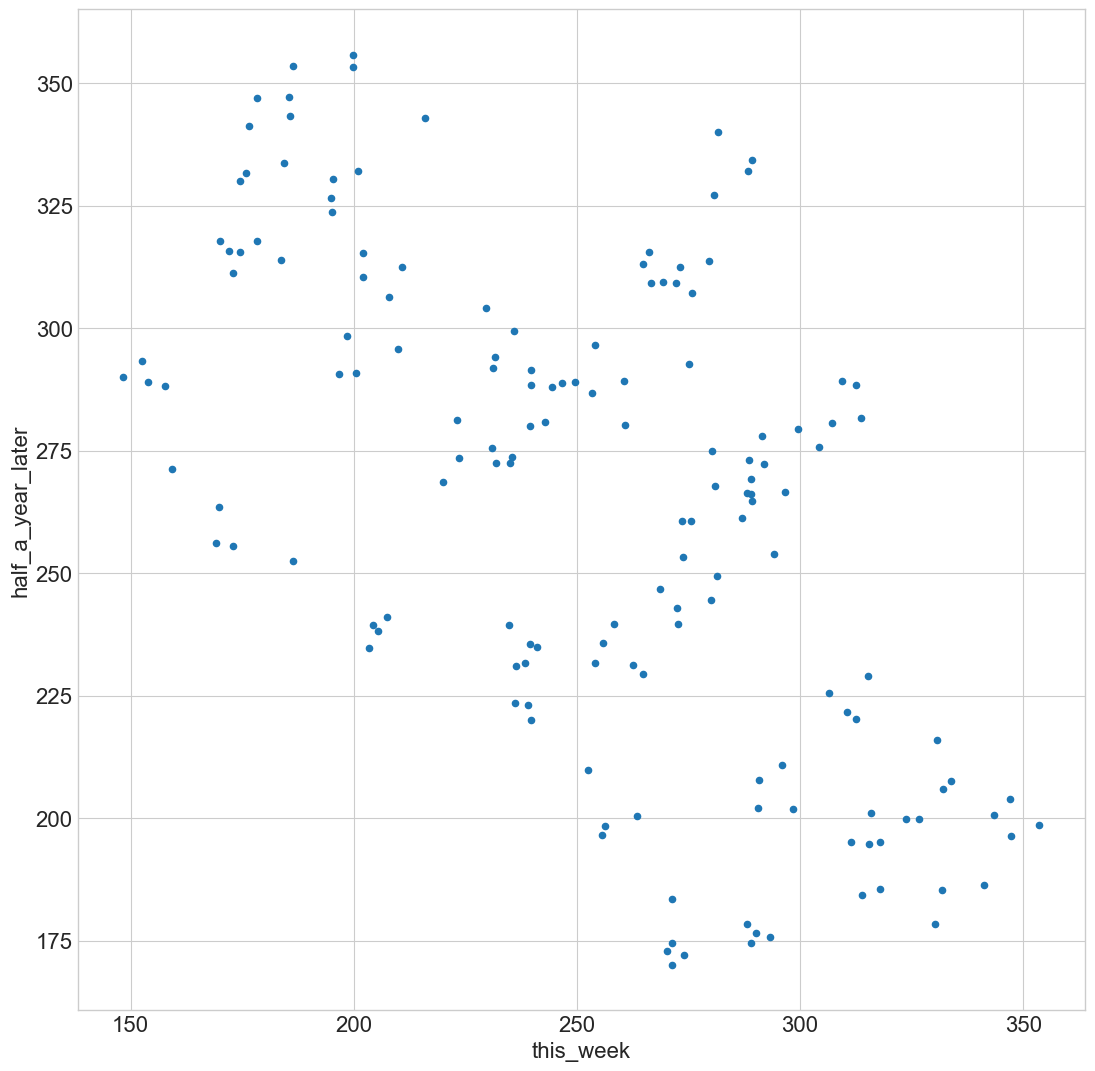

In [65]:
weekly = train.resample('W').mean()
weekly['half_a_year_later'] = weekly.sales_total.shift(-26)
weekly = weekly.rename(columns={'sales_total': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_a_year_later', figsize=(13, 13))
weekly


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

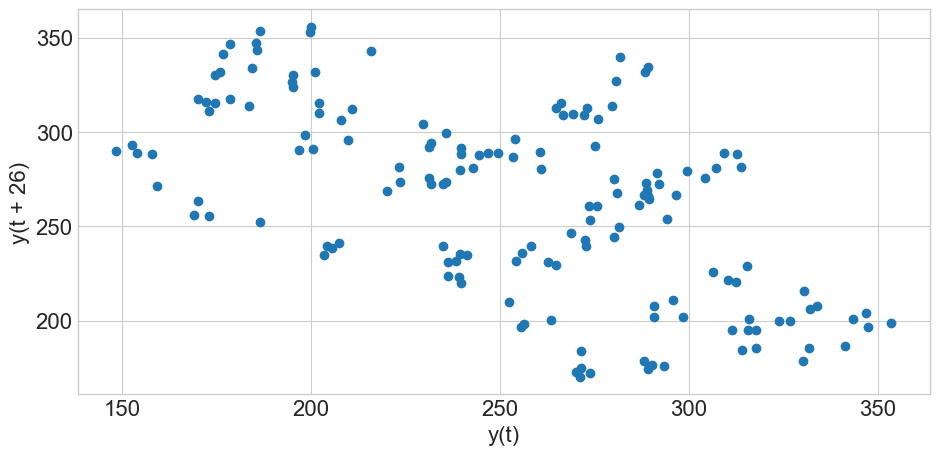

In [66]:
pd.plotting.lag_plot(train.sales_total.resample('W').mean(), lag=26)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

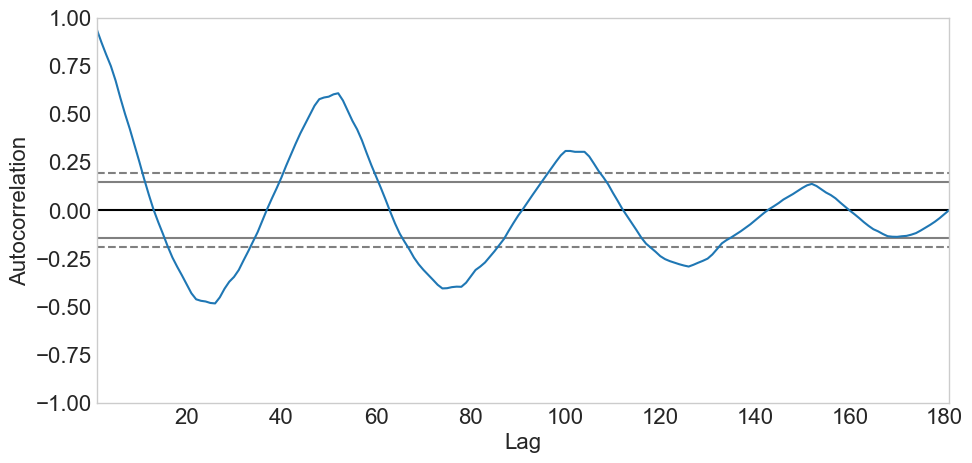

In [67]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('W').mean())


In [68]:
y = train.sales_total.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


y  trend   seasonal  resid
sale_date                                      
2013-01-06  157.809687    NaN -72.548147    NaN
2013-01-13  152.459286    NaN -74.495852    NaN
2013-01-20  153.989911    NaN -79.188663    NaN
2013-01-27  148.406518    NaN -74.737532    NaN
2013-02-03  159.180536    NaN -72.805847    NaN

<AxesSubplot:xlabel='sale_date'>

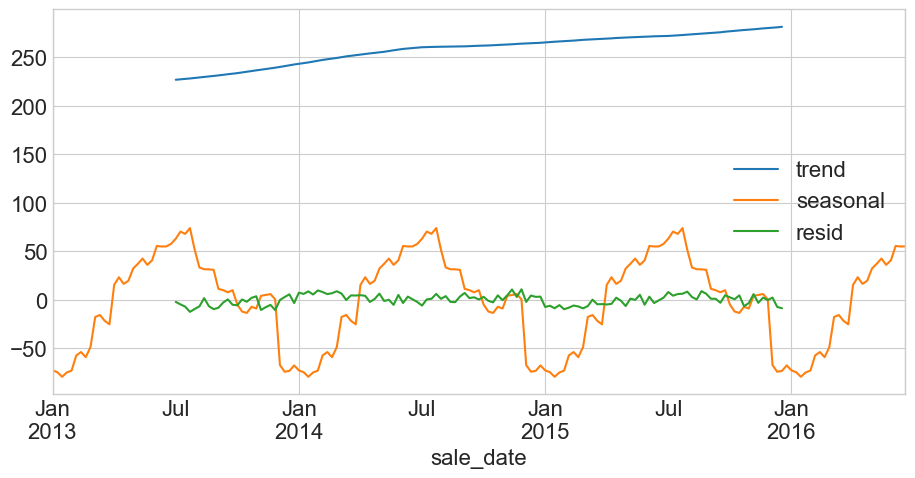

In [69]:
decomposition.iloc[:, 1:].plot()


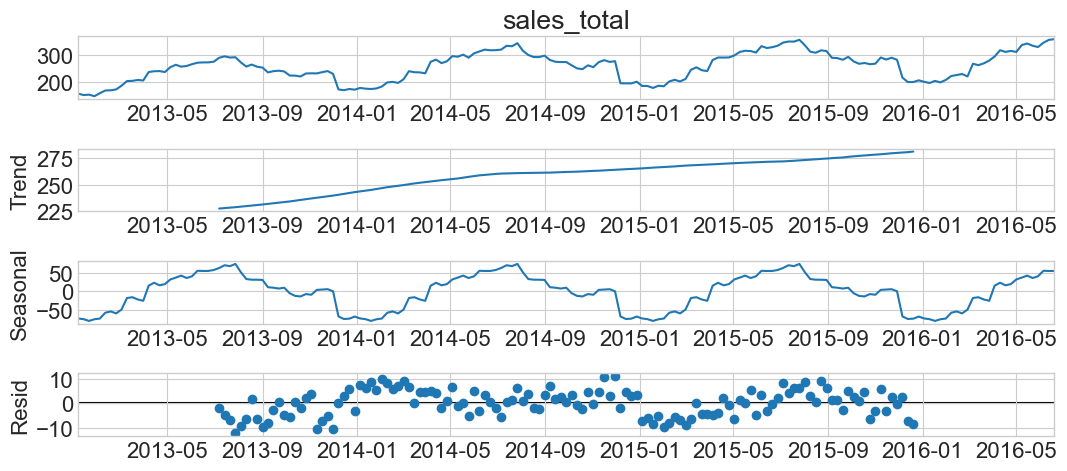

In [70]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


In [71]:
train = train.resample('D').mean()
# create a categorical feature
train['sales_bin'] = pd.qcut(train.sales_total, 4, labels=['belowavg', 'avg', 'aboveavg', 'high'])
train.groupby('sales_bin').mean()


store_id   item_id    item_upc14    item_upc12  item_price  \
sales_bin                                                               
belowavg        1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
avg             1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
aboveavg        1.0  8.500000  2.619165e+11  2.619165e+11    4.955625   
high            1.0  8.502892  2.620887e+11  2.620887e+11    4.955760   

                 sale_id  sale_amount  store_zipcode  sales_total    y(t + 1)  
sales_bin                                                                      
belowavg   137440.280757    32.429416        78253.0   178.174129  180.020919  
avg        137522.398734    42.265229        78253.0   232.547656  232.171266  
aboveavg   137619.379747    50.201543        78253.0   276.955467  277.457063  
high       137804.663512    61.248094        78253.0   337.715811  335.813974

Text(0, 0.5, '% of days in the month')

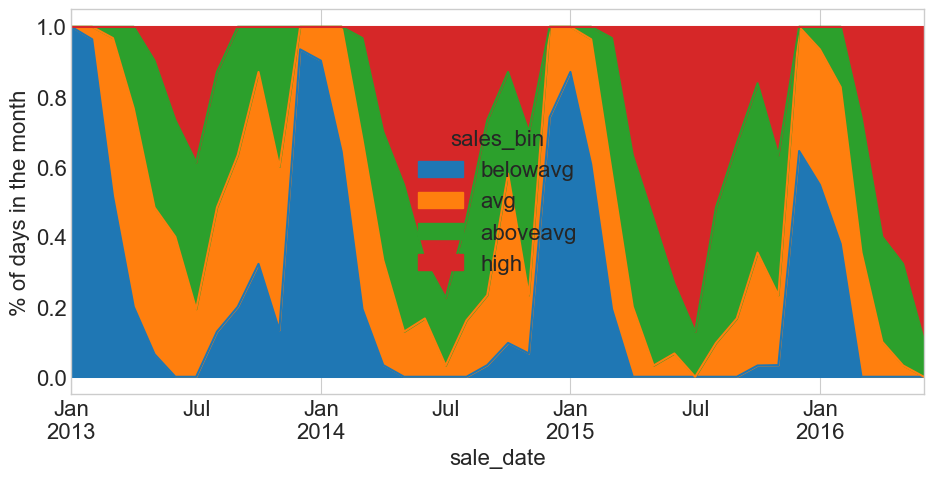

In [72]:
(train.groupby('sales_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')


[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

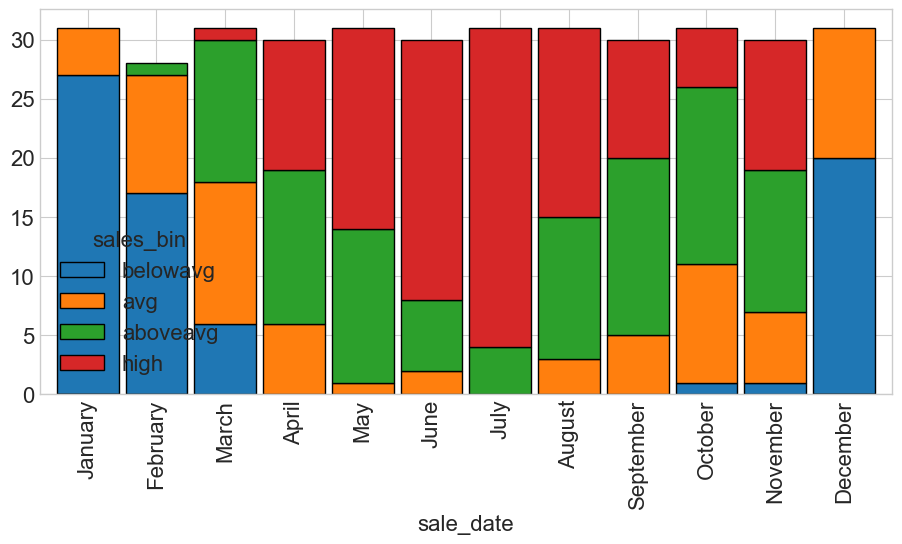

In [73]:
ax = (train['2015']
 .groupby('sales_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)


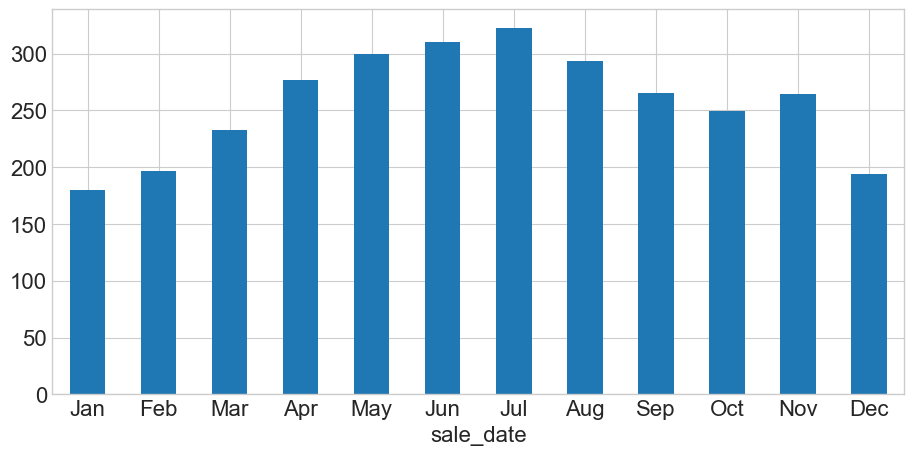

In [74]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None


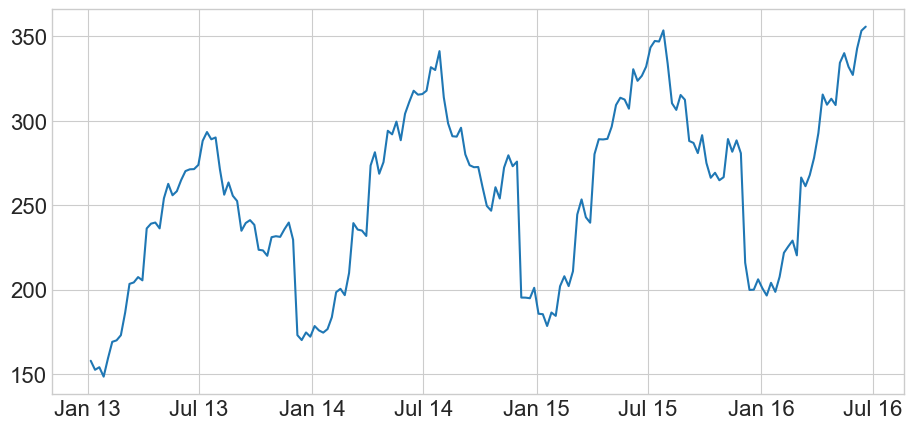

In [75]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))


# OPSD Dataset Exercise 2 

In [76]:
df = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')

In [77]:
def prep_solar(df):
    df = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')
    df['Date'] = pd.to_datetime(df.Date)
    df = df.set_index('Date').sort_index()
    df['month']=df.index.month_name()
    df['year']=df.index.year
    df=df.fillna(df.mean())
    return df

In [78]:
df = prep_solar(df)

In [79]:
df

Consumption        Wind      Solar  Wind+Solar     month  year
Date                                                                      
2006-01-01   1069.18400  164.814173  89.258695  272.663481   January  2006
2006-01-02   1380.52100  164.814173  89.258695  272.663481   January  2006
2006-01-03   1442.53300  164.814173  89.258695  272.663481   January  2006
2006-01-04   1457.21700  164.814173  89.258695  272.663481   January  2006
2006-01-05   1477.13100  164.814173  89.258695  272.663481   January  2006
...                 ...         ...        ...         ...       ...   ...
2017-12-27   1263.94091  394.507000  16.530000  411.037000  December  2017
2017-12-28   1299.86398  506.424000  14.162000  520.586000  December  2017
2017-12-29   1295.08753  584.277000  29.854000  614.131000  December  2017
2017-12-30   1215.44897  721.247000   7.467000  728.714000  December  2017
2017-12-31   1107.11488  721.176000  19.980000  741.156000  December  2017

[4383 rows x 6 columns]

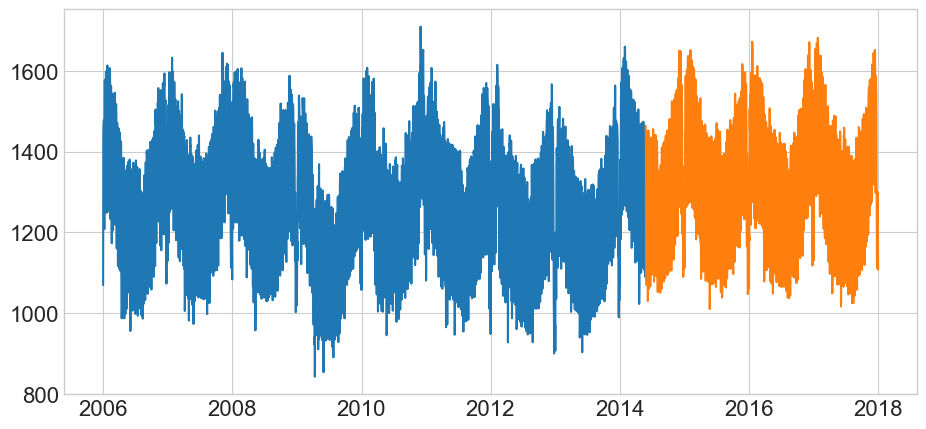

In [80]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.Consumption)
plt.plot(test.index, test.Consumption)


In [81]:
y = train.Consumption
y.head()


Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: Consumption, dtype: float64

<AxesSubplot:ylabel='Frequency'>

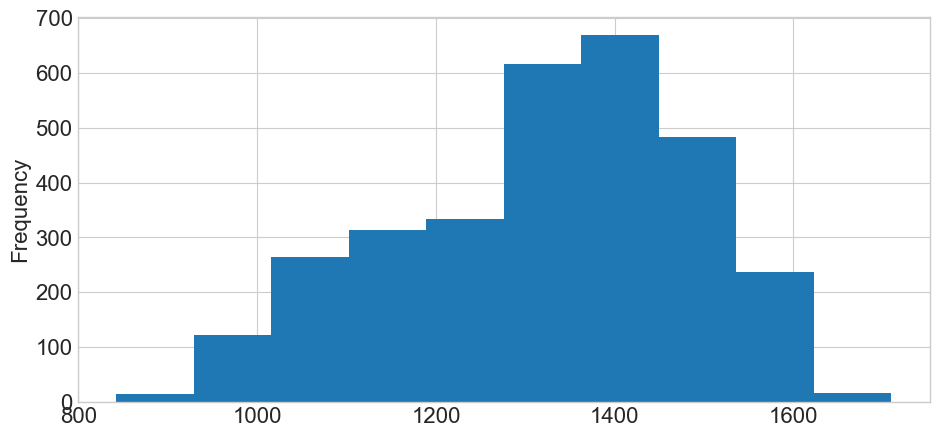

In [82]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Consumption by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Consumption')]

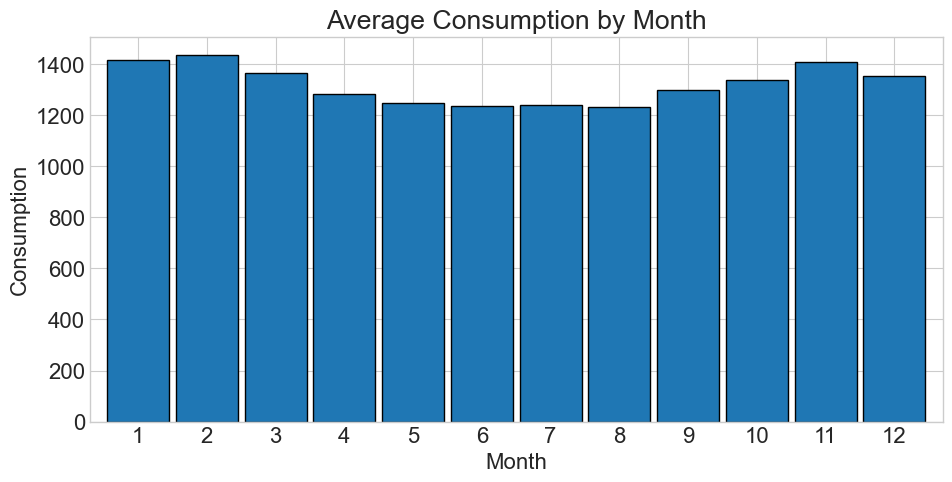

In [83]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Consumption by Month', xlabel='Month', ylabel='Consumption')


[Text(0.5, 1.0, 'Average Consumption by Weekday'),
 Text(0.5, 30.0, 'Weekday'),
 Text(30.09375, 0.5, 'Consumption')]

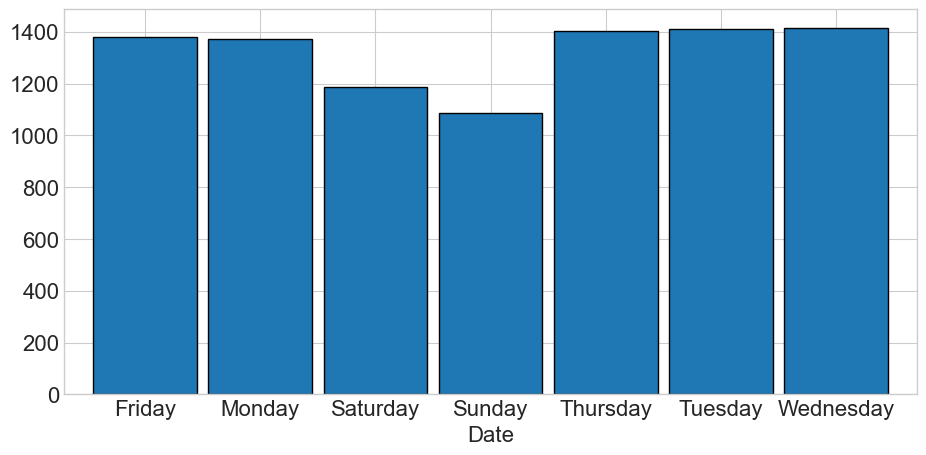

In [84]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Consumption by Weekday', xlabel='Weekday', ylabel='Consumption')


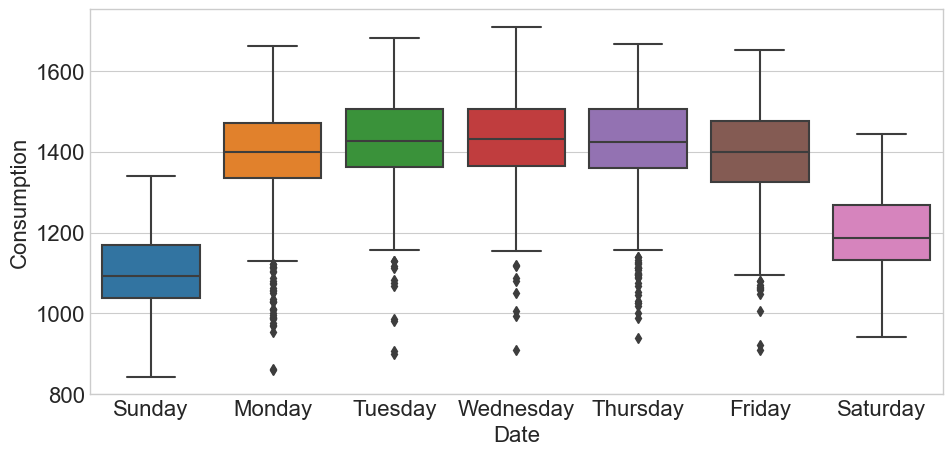

In [85]:
sns.boxplot( y=df["Consumption"], x=df.index.day_name() );
plt.show()

<AxesSubplot:xlabel='Date'>

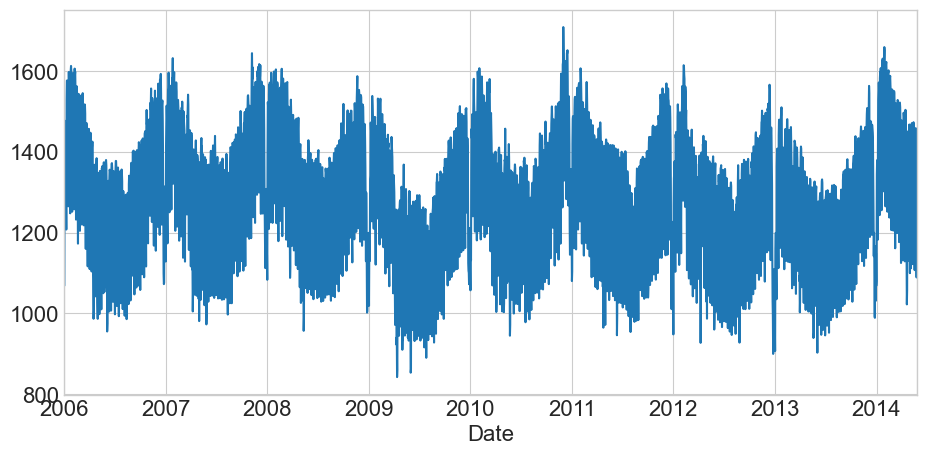

In [86]:
y.plot()


<AxesSubplot:title={'center':'1 day average'}, xlabel='Date'>

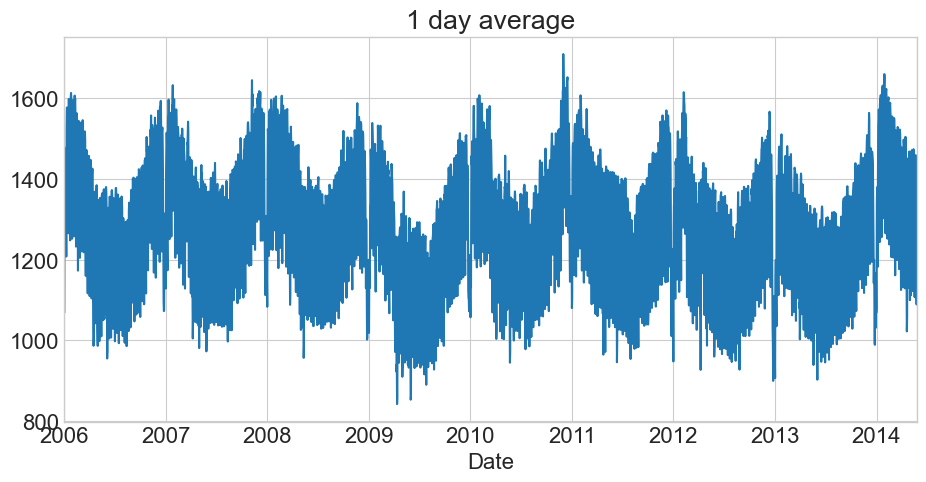

In [87]:
y.resample('1D').mean().plot(title='1 day average')


<AxesSubplot:title={'center':'2 week average'}, xlabel='Date'>

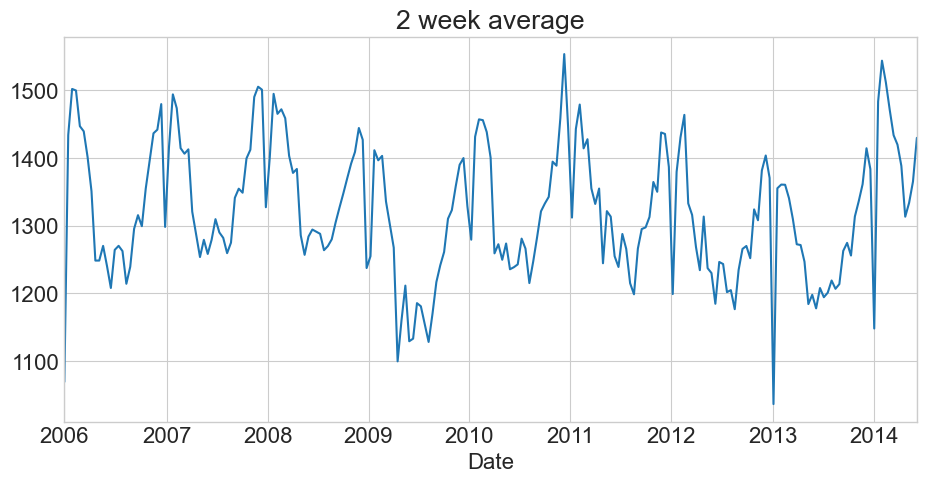

In [88]:
y.resample('2W').mean().plot(title='2 week average')


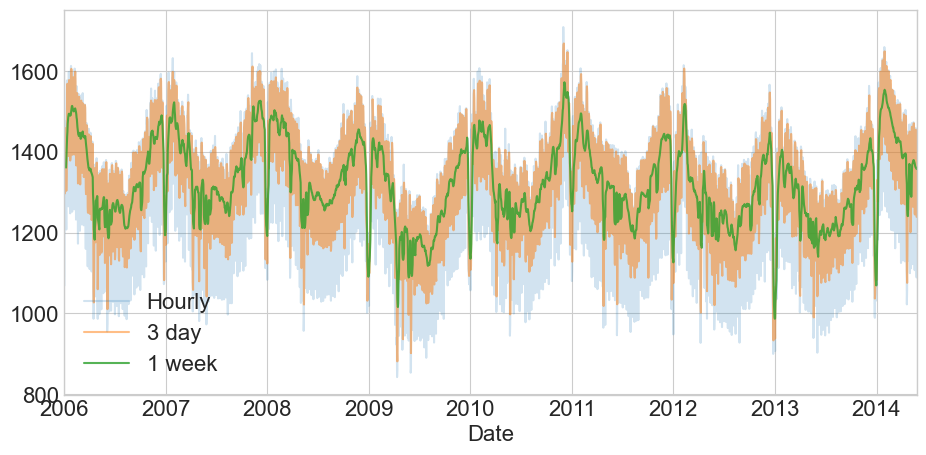

In [89]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()


<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='Date'>

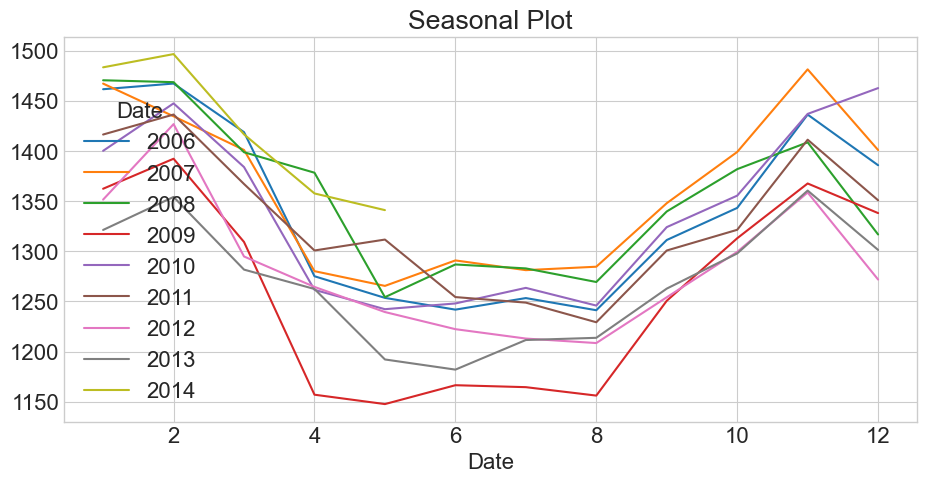

In [90]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


Text(0.5, 1.0, 'Lag plot with lag=1')

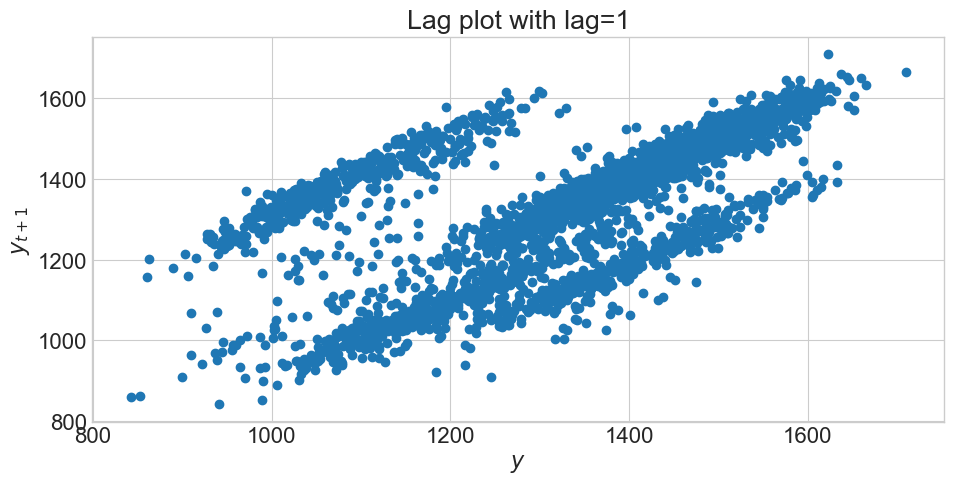

In [91]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


In [92]:
train = train.resample('D').mean()
# create a categorical feature
train['consumption_bin'] = pd.qcut(train.Consumption, 4, labels=['blow', 'low', 'mid', 'high'])
train.groupby('consumption_bin').mean()


Consumption        Wind      Solar  Wind+Solar         year
consumption_bin                                                             
blow             1087.649859  143.625284  87.626394  259.300812  2009.886571
low              1289.750096  136.186978  94.602202  256.022495  2009.889179
mid              1393.519502  138.040033  83.218526  253.616290  2009.615385
high             1515.531231  152.781659  81.326684  254.703707  2009.466754

ParserError: Unknown string format: (2008-01-31 00:00:00, blow)

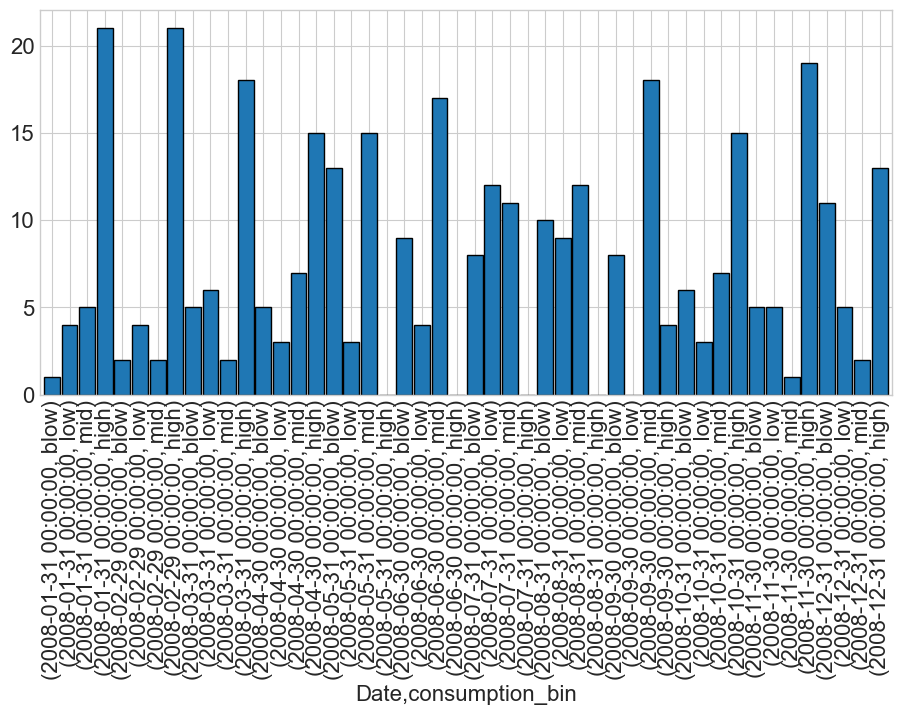

In [93]:
ax = (train['2008']
 .groupby('consumption_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)



In [ ]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None


In [ ]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
